# Bank Customer Churn -  Ensemble Learning 


In [1]:
#![churn_bank.jpg](attachment:churn_bank.jpg)

# Importando Bibliotecas 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import logging
import optuna
import xgboost as xgb
import torch
import torch.nn as nn
import shap
import lime.lime_tabular
import scipy.sparse
from sklearn.inspection import PartialDependenceDisplay
from xgboost import plot_importance
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    roc_curve, confusion_matrix, auc
)

from optuna.samplers import TPESampler
import pickle
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import joblib

from imblearn.over_sampling import SMOTE





########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [3]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Analisando primeiras impressões da base de dados


In [4]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])


Numero de linhas: 10000
Numero de colunas: 18


In [5]:
#tipos
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [6]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [7]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in base_original.columns:
    zero_count = (base_original[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

#nao foi constatao nada muito impactante, as variaveis com mais zero sao categoriacas (binarias) 
# Balance seria a unica a se preocupar, mas vamos manter. 






 'RowNumber': 0 valores zero

 'CustomerId': 0 valores zero

 'Surname': 0 valores zero

 'CreditScore': 0 valores zero

 'Geography': 0 valores zero

 'Gender': 0 valores zero

 'Age': 0 valores zero

 'Tenure': 413 valores zero

 'Balance': 3617 valores zero

 'NumOfProducts': 0 valores zero

 'HasCrCard': 2945 valores zero

 'IsActiveMember': 4849 valores zero

 'EstimatedSalary': 0 valores zero

 'Exited': 7962 valores zero

 'Complain': 7956 valores zero

 'Satisfaction Score': 0 valores zero

 'Card Type': 0 valores zero

 'Point Earned': 0 valores zero


In [8]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname

#removida Gender por poder inviesar o modelo de alguma formna descriminativa, é uma boa pratica de LGPD nao usar dados sensiveis como esse etc. 
 

df = base_original[['CreditScore',
                    #'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,"10.000,0","10.000,0","10.000,0","10.000,0","10.000,0","10.000,0"
mean,"100.090,2","76.485,9","650,5","38,9","5,0","606,5"
std,"57.510,5","62.397,4","96,7","10,5","2,9","225,9"
min,"11,6","0,0","350,0","18,0","0,0","119,0"
25%,"51.002,1","0,0","584,0","32,0","3,0","410,0"
50%,"100.193,9","97.198,5","652,0","37,0","5,0","605,0"
75%,"149.388,2","127.644,2","718,0","44,0","7,0","801,0"
max,"199.992,5","250.898,1","850,0","92,0","10,0","1.000,0"


* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


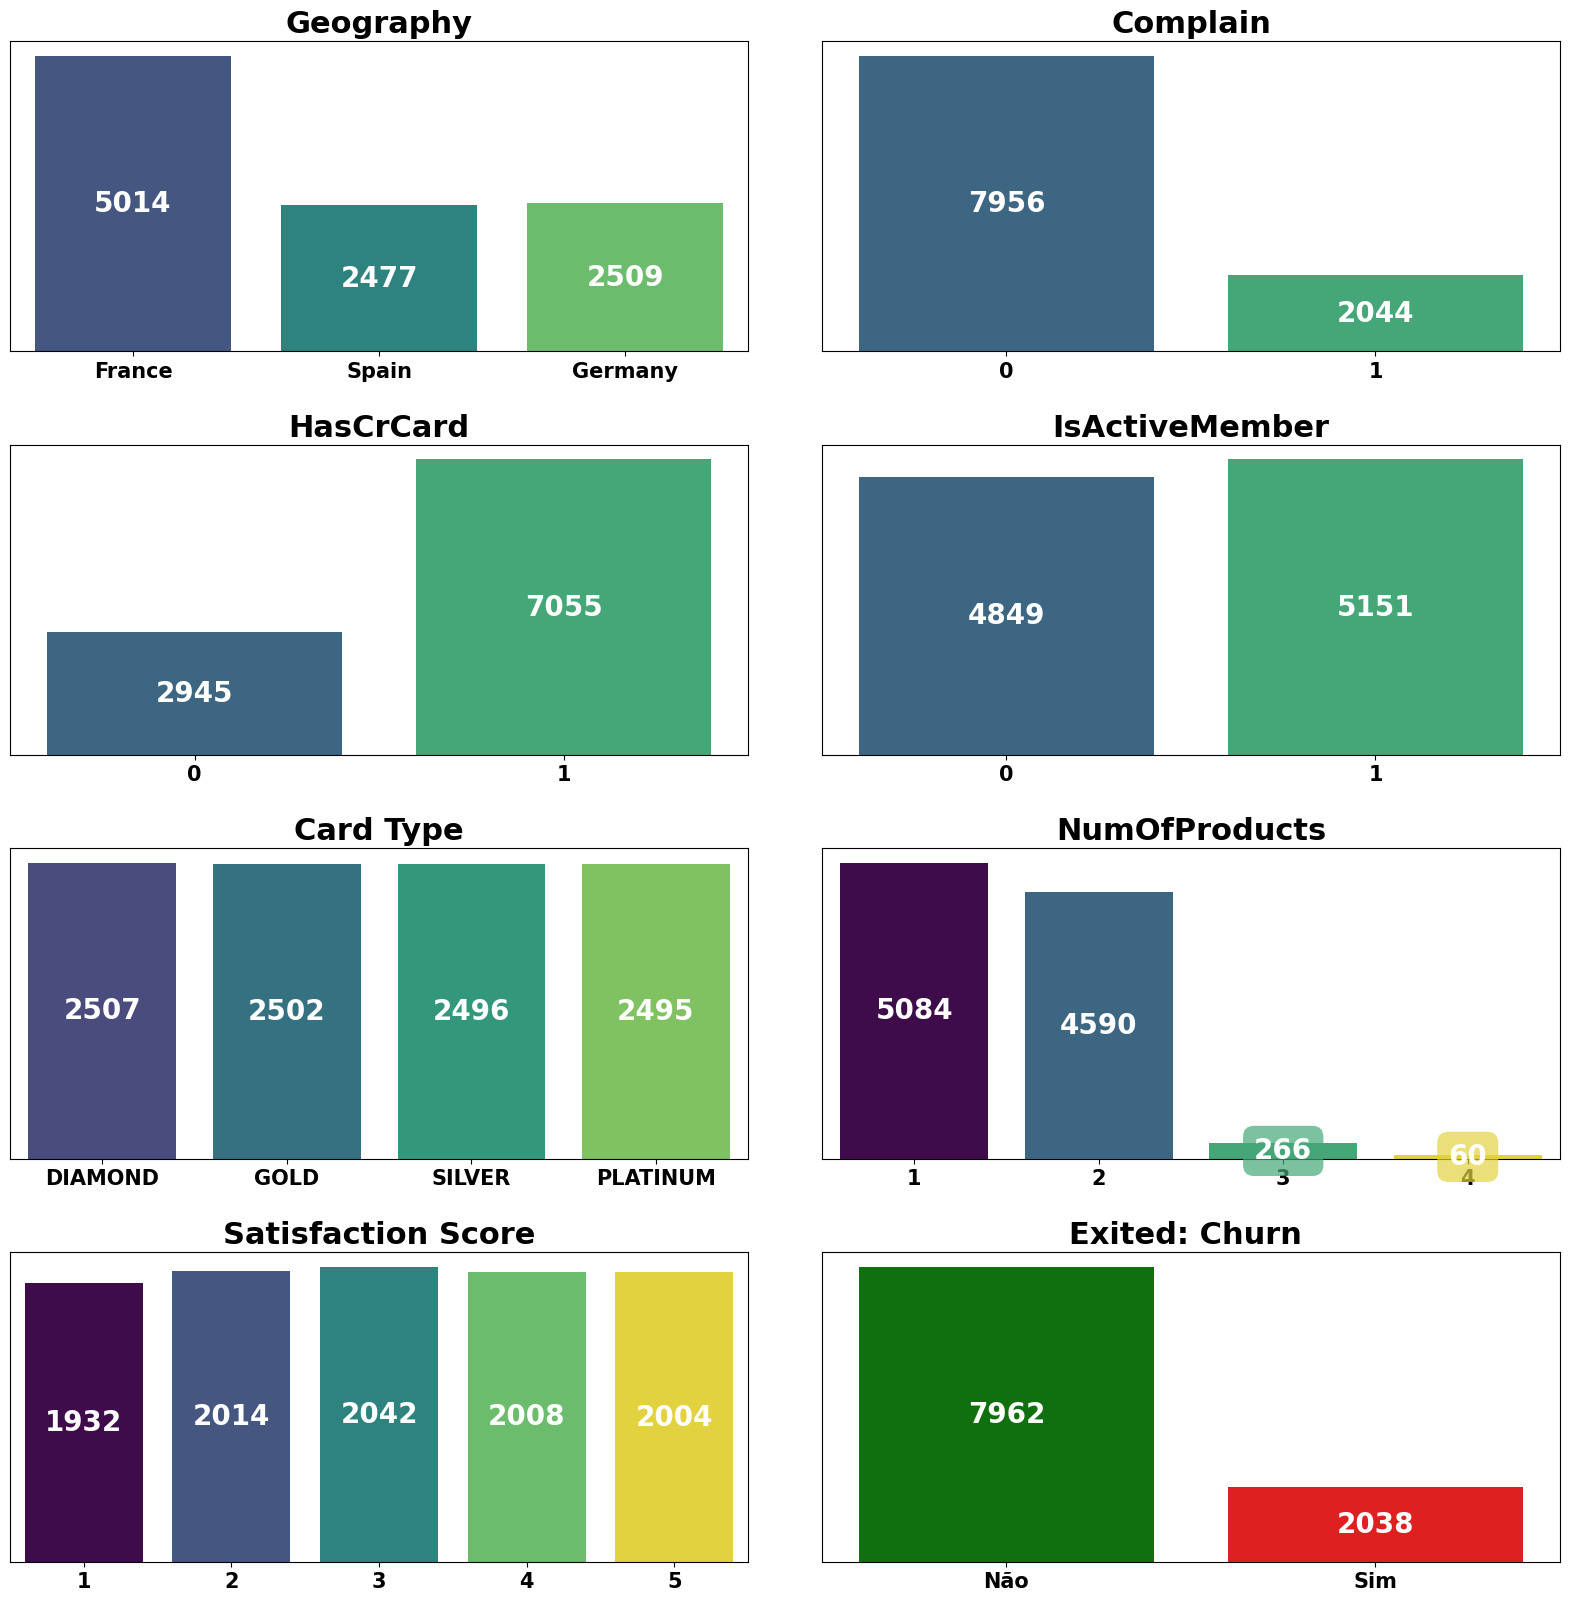

In [9]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 
            'IsActiveMember', 
            'Geography',
            #'Gender',
            'Complain',
            'Exited',
            'Card Type',
            'NumOfProducts',
            'Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)


# Complain
plt.subplot(5, 2, 2)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 3)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 4)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 5)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 7)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



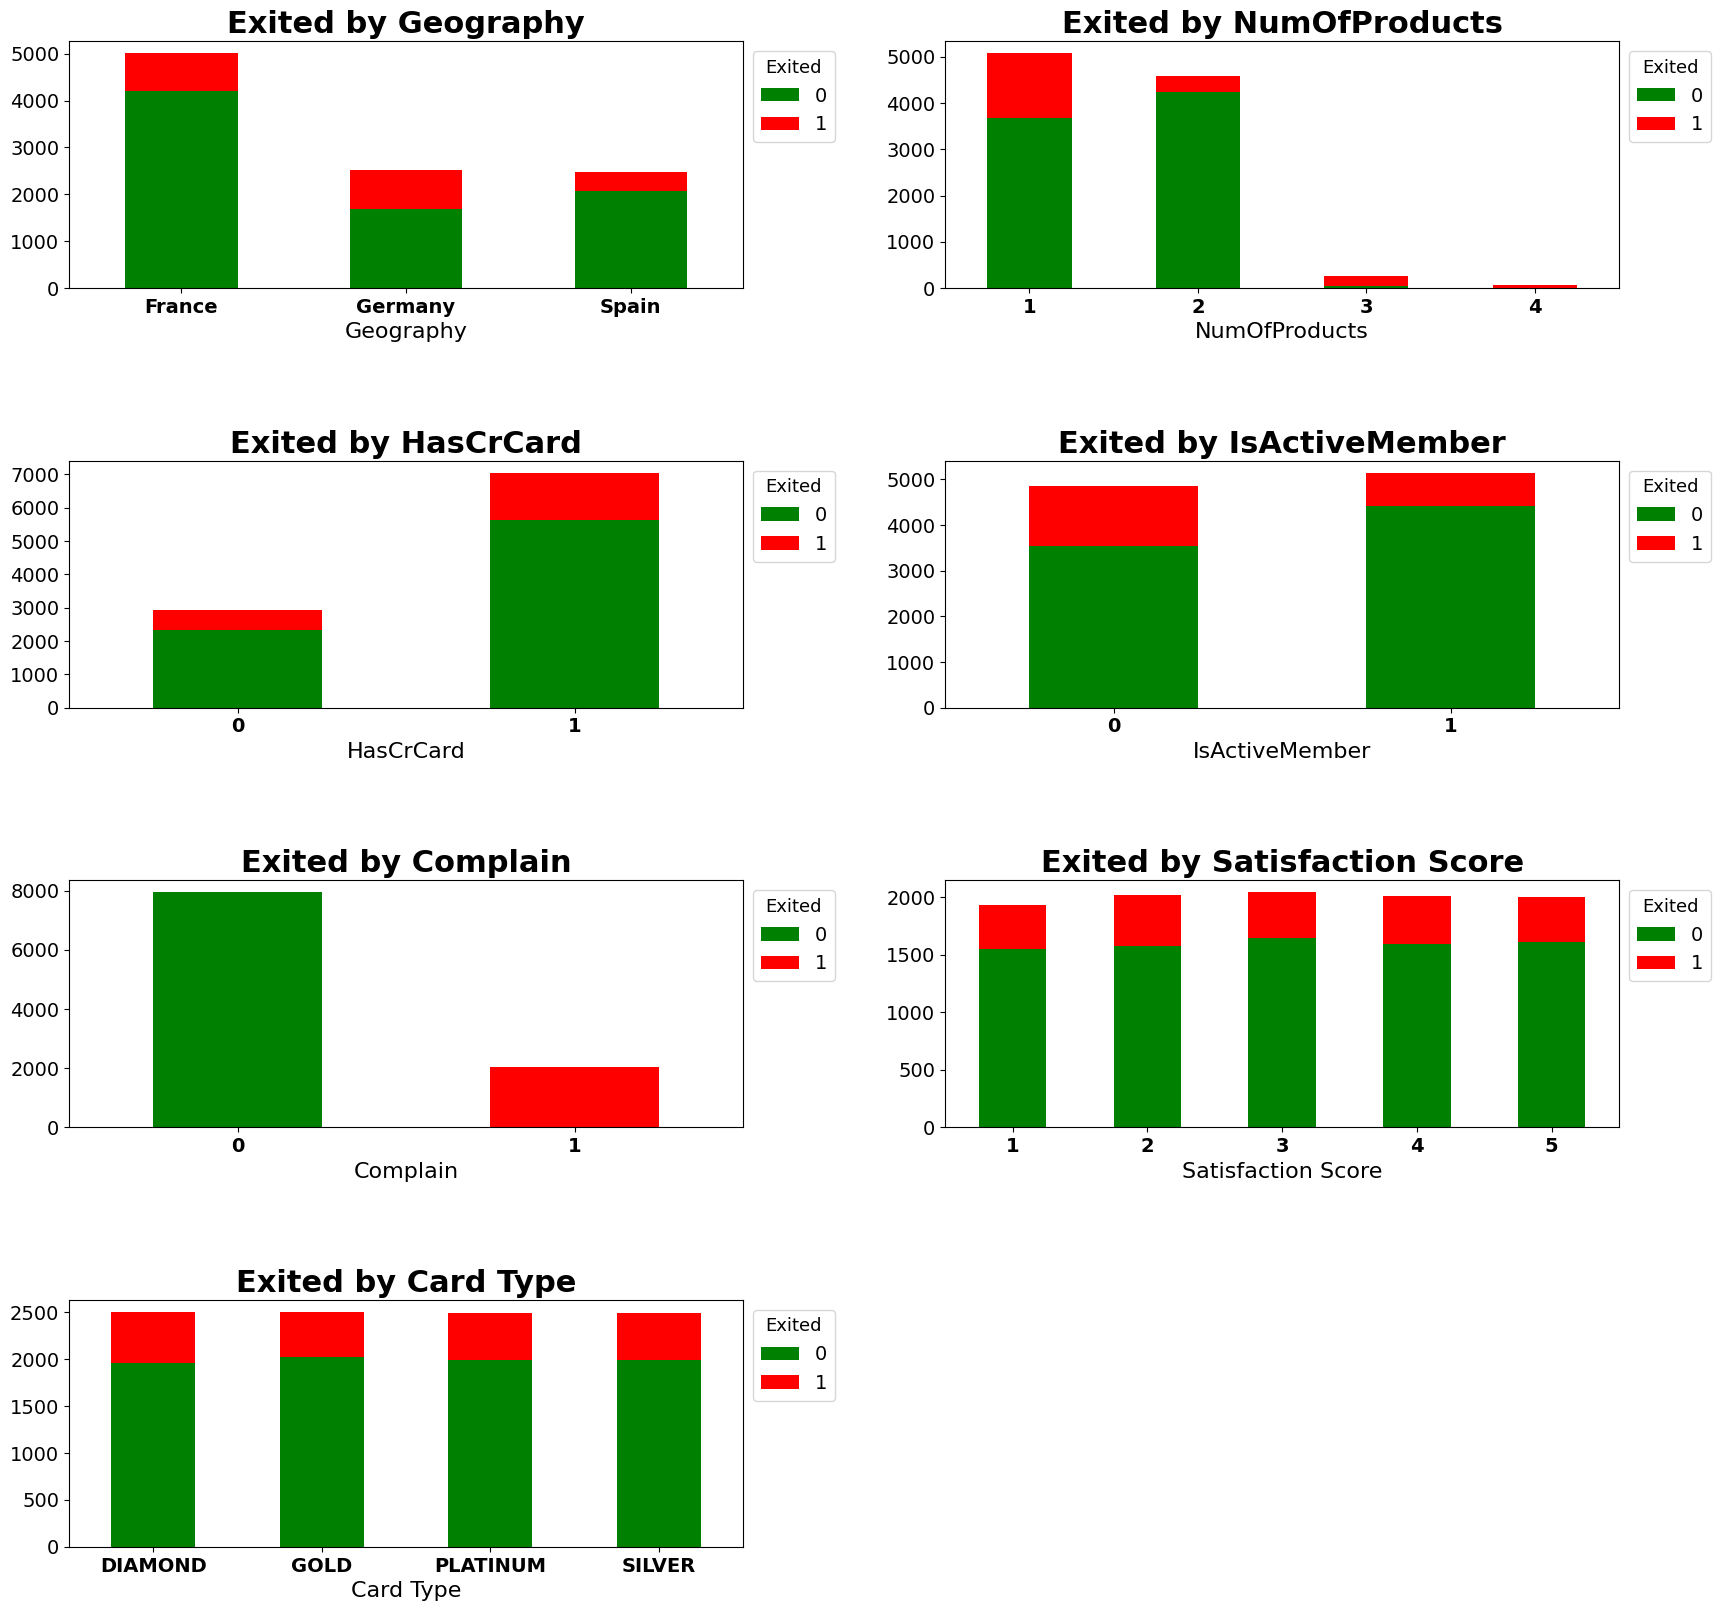

In [10]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)


# NumOfProducts
plt.subplot(5, 2, 2)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 3)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 4)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 5)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo atual e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 

* foi necessario aplicar Ordinal-Encoder. 

In [11]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean)
warnings.filterwarnings('ignore', category=FutureWarning)

# Lista de variáveis a serem transformadas
cols_to_transform = ['Geography']

# Convertendo para string (somente a coluna "Geography")
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# Realizando o One-Hot Encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=True) 
#se o modelo/modelos forem afetados drasticamntee por multicolineariadde drop_first=True deve ser melhor, pois dropa uma das variaveis dummie. Os demais nao feta tanto, mas e boa pratica

# Ordinal-Encoder 
df_dummies['Card Type'] = OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]], dtype=int).fit_transform(df_dummies[['Card Type']])

# Variável alvo 'Exited' para o tipo numérico (se necessário)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Card Type               int32
Point Earned            int64
Exited                  int64
Geography_Germany       int32
Geography_Spain         int32
dtype: object


# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso esse modelo captura naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


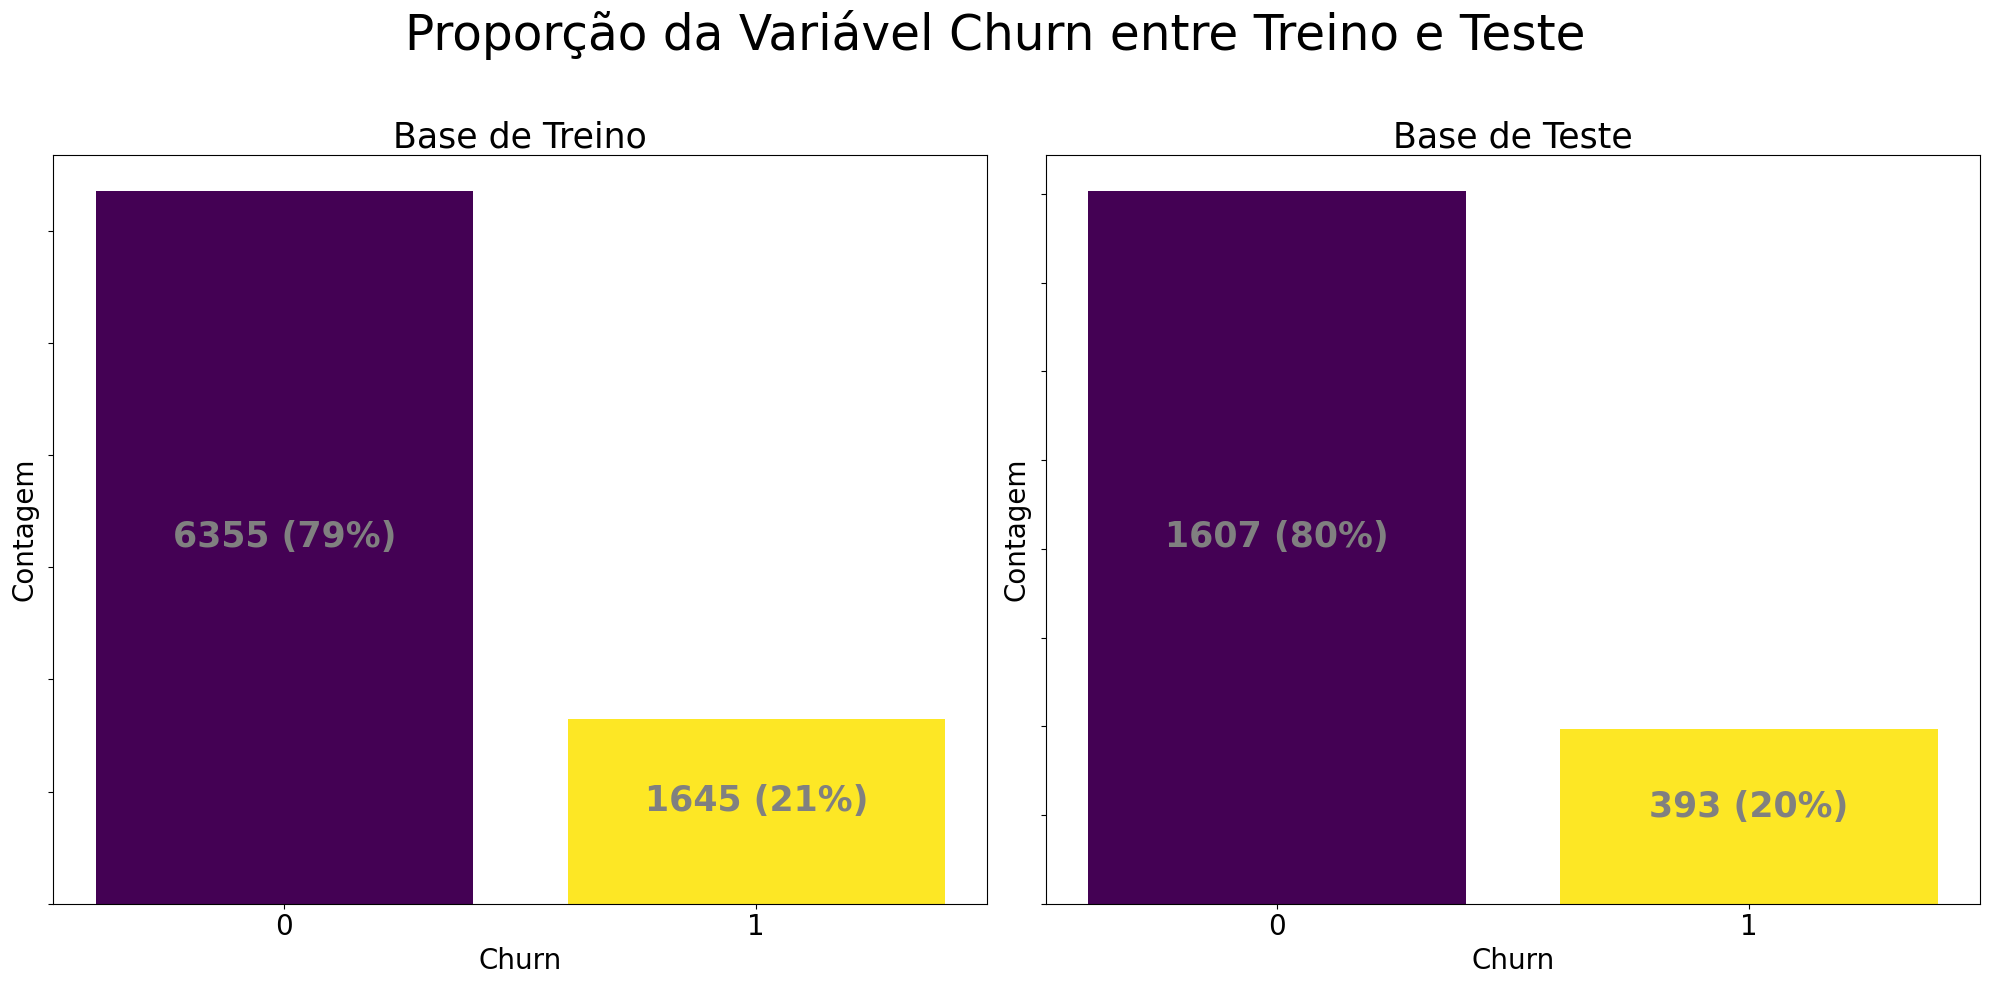

In [12]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain']) #correlacao altissima com a variavel alvo


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da deste modelo (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



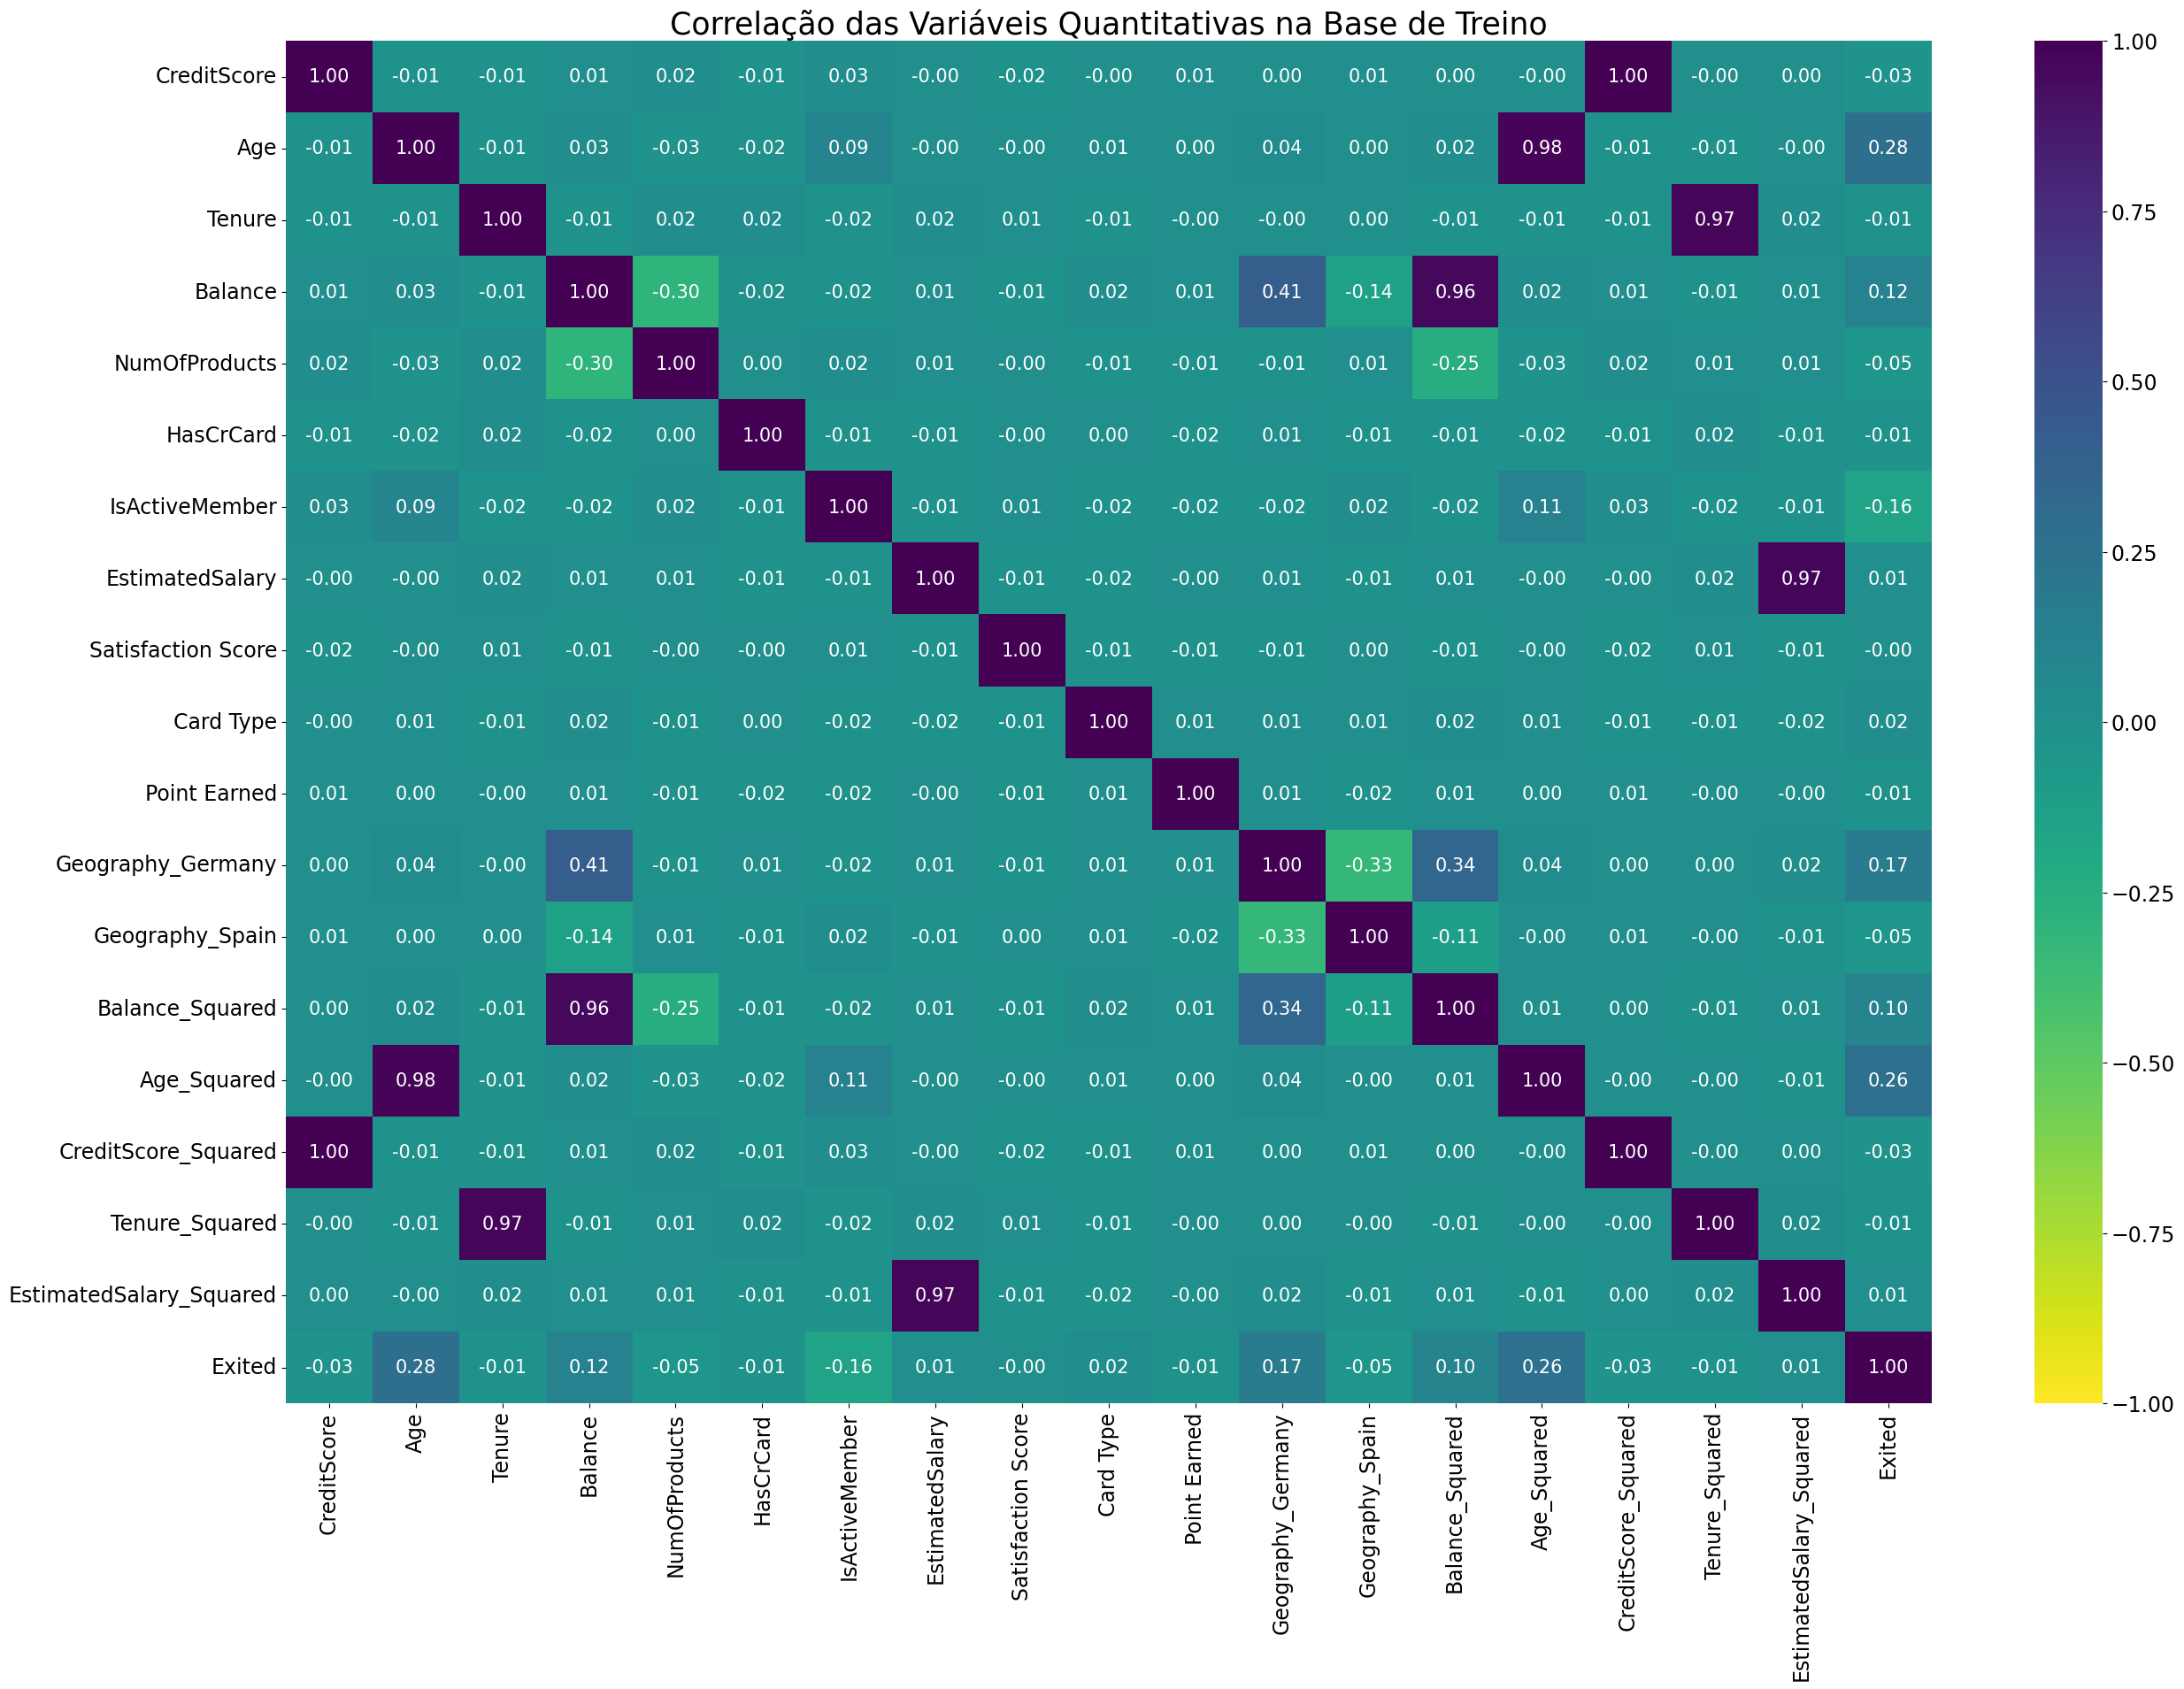

In [13]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

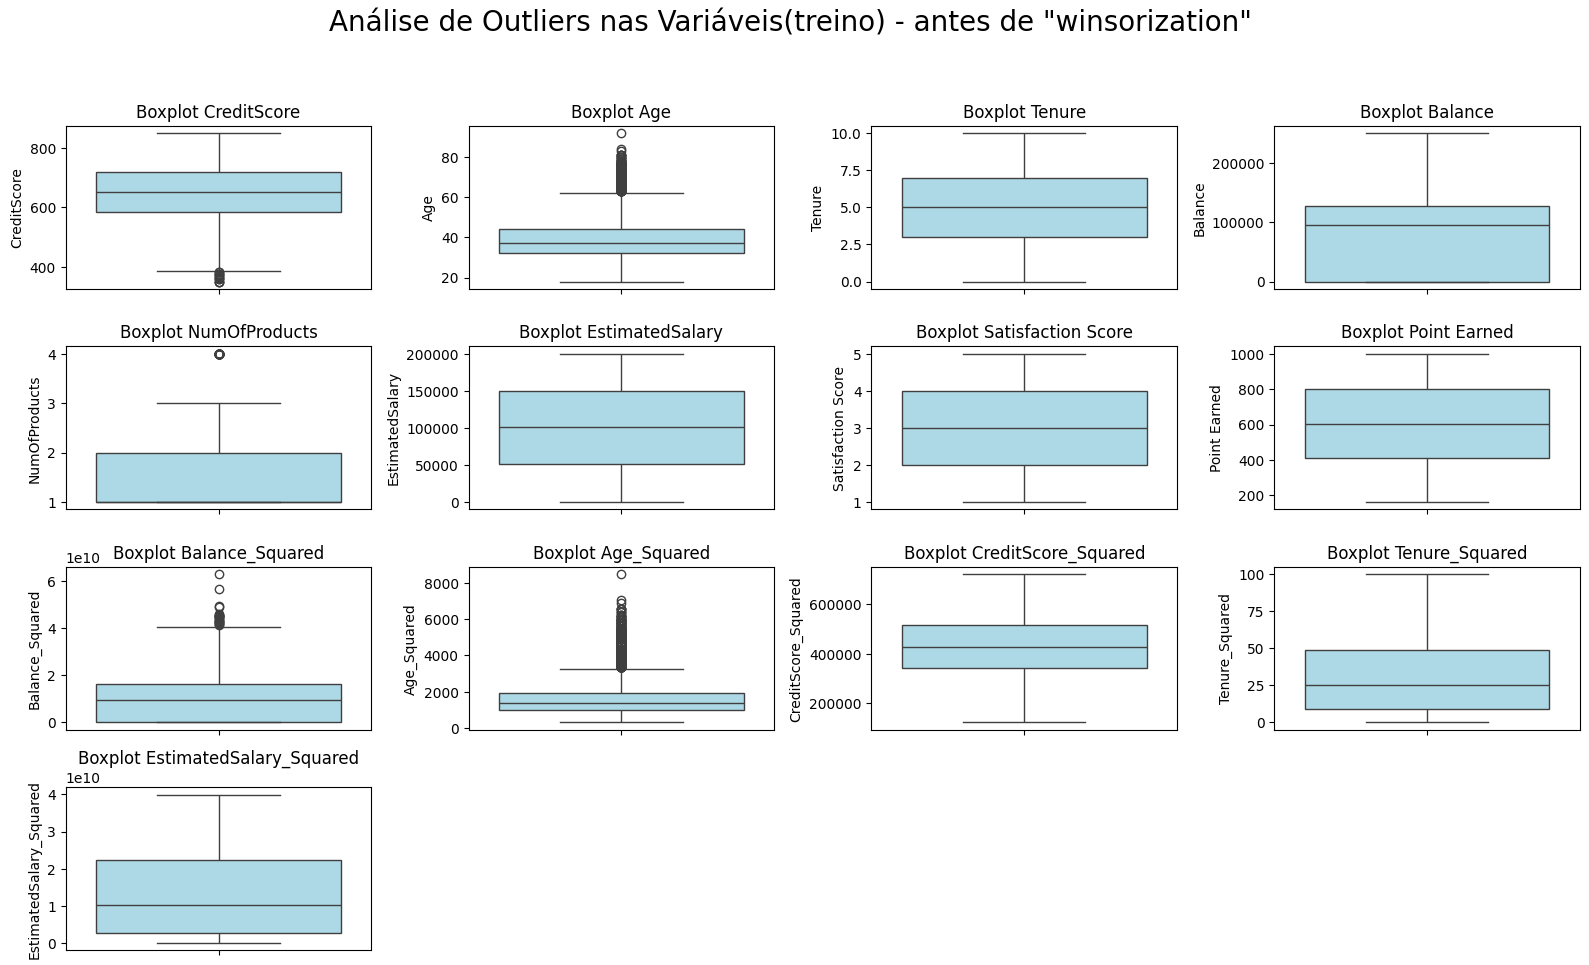

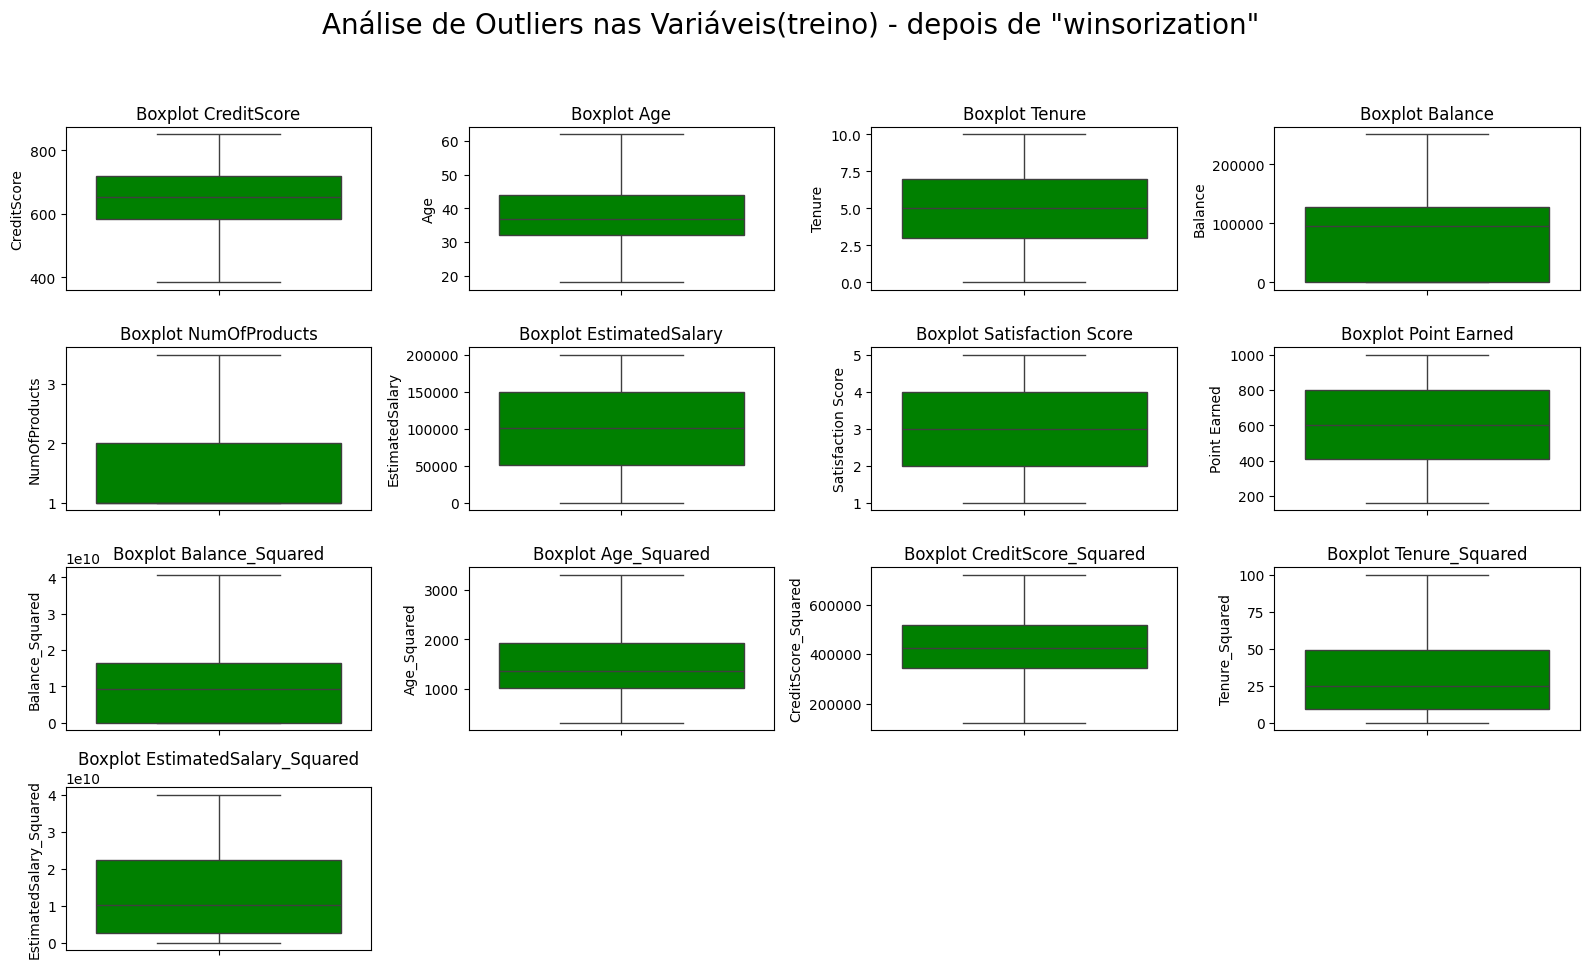

In [14]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

In [15]:
#BASE DE TREINO 
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9254,686.0,32.0,6.0,0.00,2.0,1,1,179093.26,2.0,3,510.0,0,0,0.000000e+00,1024.0,470596.0,36.0,3.207440e+10,0
1561,632.0,42.0,4.0,119624.60,2.0,1,1,195978.86,4.0,2,959.0,1,0,1.431004e+10,1764.0,399424.0,16.0,3.840771e+10,0
1670,559.0,24.0,3.0,114739.92,1.0,1,0,85891.02,4.0,0,327.0,0,1,1.316525e+10,576.0,312481.0,9.0,7.377267e+09,1
6087,561.0,27.0,9.0,135637.00,1.0,1,0,153080.40,2.0,0,567.0,0,0,1.839740e+10,729.0,314721.0,81.0,2.343361e+10,1
6669,517.0,56.0,9.0,142147.32,1.0,0,0,39488.04,3.0,2,727.0,0,0,2.020586e+10,3136.0,267289.0,81.0,1.559305e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8.0,69712.74,1.0,1,1,69381.05,3.0,0,569.0,0,0,4.859866e+09,2916.0,589824.0,64.0,4.813730e+09,0
5191,682.0,58.0,1.0,0.00,1.0,1,1,706.50,4.0,2,709.0,0,0,0.000000e+00,3304.0,465124.0,1.0,4.991422e+05,0
5390,735.0,38.0,1.0,0.00,3.0,0,0,92220.12,5.0,0,678.0,0,0,0.000000e+00,1444.0,540225.0,1.0,8.504551e+09,1
860,667.0,43.0,8.0,190227.46,1.0,1,0,97508.04,3.0,3,680.0,0,0,3.618649e+10,1849.0,444889.0,64.0,9.507818e+09,1


In [16]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,0,0,41788.37,1,1,709,1,0,9.352644e+09,1024,355216,9,1.746268e+09,0
4684,623,43,1,0.00,2,1,1,146379.30,2,0,508,0,0,0.000000e+00,1849,388129,1,2.142690e+10,0
1731,601,44,4,0.00,2,1,0,58561.31,1,1,281,0,1,0.000000e+00,1936,361201,16,3.429427e+09,0
4742,506,59,8,119152.10,2,1,1,170679.74,2,0,979,1,0,1.419722e+10,3481,256036,64,2.913157e+10,0
4521,560,27,7,124995.98,1,1,1,114669.79,5,0,457,0,1,1.562400e+10,729,313600,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5,98268.84,1,0,1,45038.29,5,2,813,1,0,9.656765e+09,2809,362404,25,2.028448e+09,1
8285,609,25,10,0.00,1,0,1,109895.16,2,2,652,0,0,0.000000e+00,625,370881,100,1.207695e+10,0
7853,730,47,7,0.00,1,1,0,33373.26,2,2,504,0,0,0.000000e+00,2209,532900,49,1.113774e+09,1
1095,692,29,4,0.00,1,1,0,76755.99,3,2,686,0,0,0.000000e+00,841,478864,16,5.891482e+09,1


# Preparacao dos dados  


* Preparacao dos dados 


------------------------
 DATA Prep
------------------------
------------------------
Início: 2025-03-13 19:05:55.283694
------------------------
Índices de X_test e y_test já estavam alinhados.


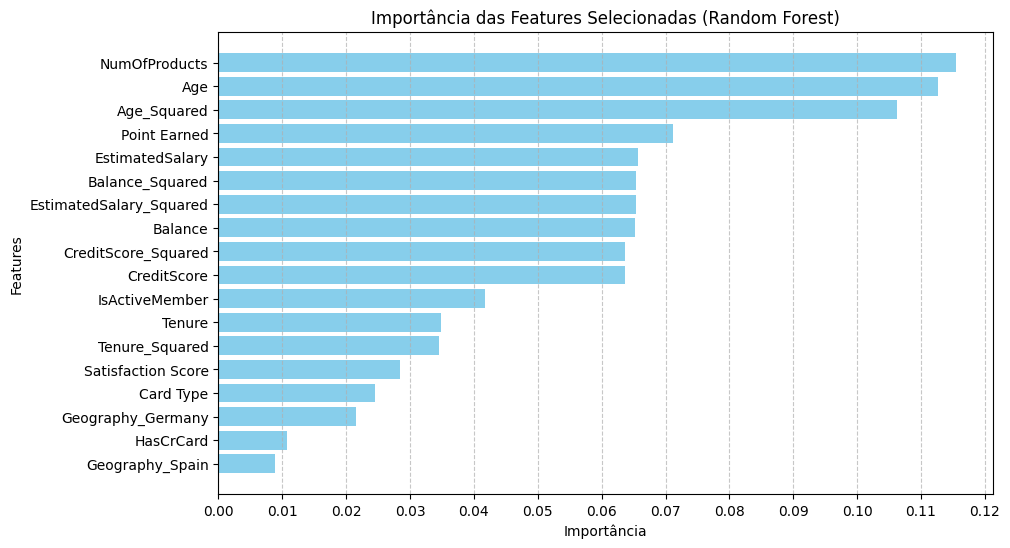

In [17]:
print('------------------------')
print(" DATA Prep")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 



# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 
#detalhe importante, nao tem predict(), somente o fit() 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()




# Finalizando preparacao e selecionando variaveis

Variaveis selecionadas conforme o modelo classificador de importancia usado anteriormente (randomforest) 

In [18]:

print("Shape X_train antes de selecionar as fetuares importantes:", X_train.shape)
print("Shape y_train antes de selecionar as fetuares importantes:", y_train.shape)


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train, y_train = X_train_selected , y_train
X_test, y_test = X_test_selected , y_test

print("Shape X_train (selecionadas):", X_train.shape)
print("Shape y_train (selecionadas):", y_train.shape)

print("Shape X_test (selecionadas):", X_test.shape)
print("Shape y_test (selecionadas):", y_test.shape)


#verificando alinhamneto
assert X_train.shape[0] == y_train.shape[0], "Erro: Número de amostras não coincide"
assert X_test.shape[0] == y_test.shape[0], "Erro: Número de amostras não coincide"


Shape X_train antes de selecionar as fetuares importantes: (8000, 18)
Shape y_train antes de selecionar as fetuares importantes: (8000,)
Tempo de Início: 2025-03-13 19:06:00.754011
------------------------
Shape X_train (selecionadas): (8000, 17)
Shape y_train (selecionadas): (8000,)
Shape X_test (selecionadas): (2000, 17)
Shape y_test (selecionadas): (2000,)


# **Ensemble Model - Aplicando modelos salvos anteriormente e conferindo resultados** 


📊 MÉTRICAS DO MODELO CATboost nos dados de teste
Métrica             Valor final    
------------------------------------------------------------
Acurácia           0.6695
Precisão            0.3607
Recall              0.8830
F1-Score            0.5122
AUC-ROC             0.8660
MCC                 0.3978
Kappa de Cohen       0.3234
Acurácia Balanceada 0.7501


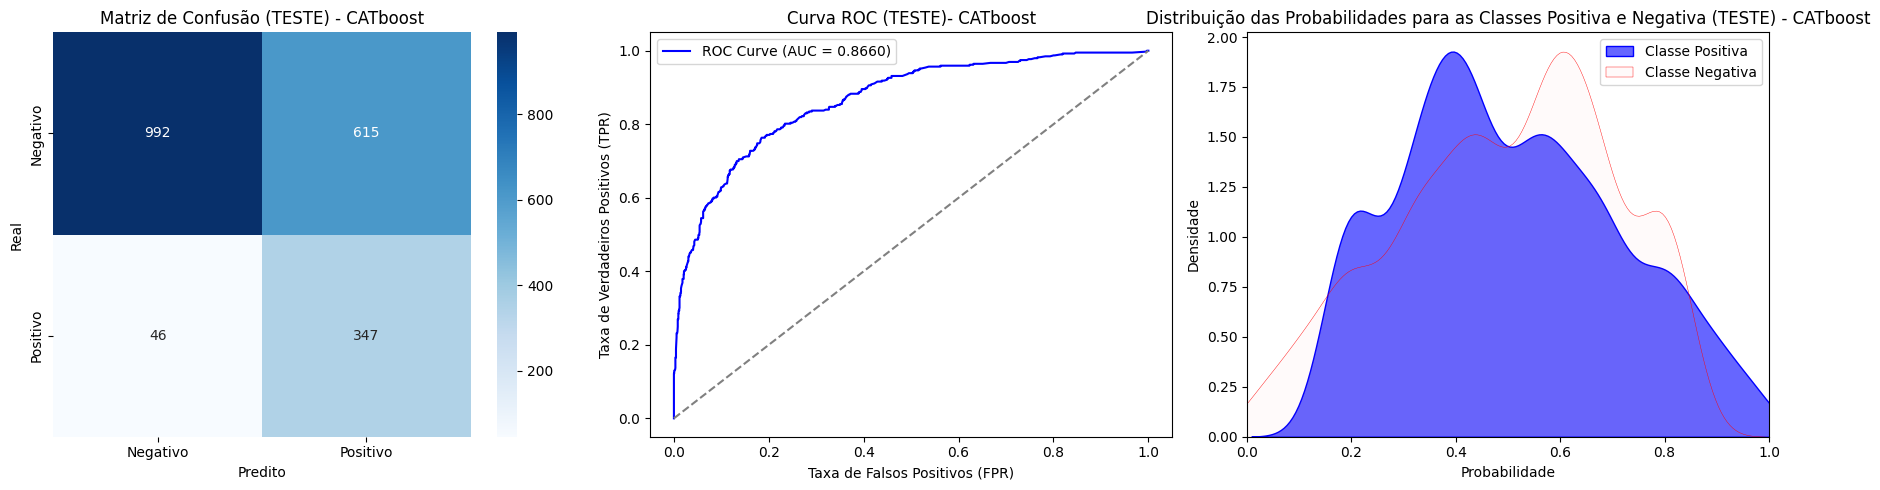

In [19]:
#Catboost

import pickle
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, confusion_matrix, roc_curve
)


# Caminhos dos arquivos
modelo_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\CATboost\catboost_model.pkl"
scaler_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\CATboost\scaler.pkl"

# Carregar o modelo treinado
with open(modelo_path, 'rb') as file:
    model_catboost = pickle.load(file)

# Carregar o scaler
with open(scaler_path, 'rb') as file:
    scaler_catboost = pickle.load(file)

# Normalizar os dados de teste
X_test_scaled = scaler_catboost.transform(X_test_selected)

# Fazer previsões
y_pred = model_catboost.predict(X_test_scaled)
y_pred_proba = model_catboost.predict_proba(X_test_scaled)[:, 1]  # Probabilidade da classe positiva

# Converter para DataFrame para análise
#df_pred = pd.DataFrame({
#    "y_real": y_test.values,  # Se `y_test` for DataFrame, pegar `.values`
#    "y_pred": y_pred,
#    "y_pred_proba": y_pred_proba
#})

# Exibir as primeiras linhas das previsões
#print(df_pred.head())


# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Exibir as métricas no formato desejado
print("\n📊 MÉTRICAS DO MODELO CATboost nos dados de teste")
print("=" * 60)
print(f"{'Métrica':<20}{'Valor final':<15}")
print("-" * 60)
print(f"Acurácia{' ' * 11}{accuracy:.4f}")
print(f"Precisão{' ' * 12}{precision:.4f}")
print(f"Recall{' ' * 14}{recall:.4f}")
print(f"F1-Score{' ' * 12}{f1:.4f}")
print(f"AUC-ROC{' ' * 13}{auc_roc:.4f}")
print(f"MCC{' ' * 17}{mcc:.4f}")
print(f"Kappa de Cohen{' ' * 7}{kappa:.4f}")
print(f"Acurácia Balanceada {balanced_acc:.4f}")
print("=" * 60)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"], ax=axes[0])
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de Confusão (TESTE) - CATboost")

# Plot da Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_roc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc_value:.4f})", color="blue")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal
axes[1].set_xlabel("Taxa de Falsos Positivos (FPR)")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
axes[1].set_title("Curva ROC (TESTE)- CATboost")
axes[1].legend()

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_proba  
# classe negativa
probs_neg = 1 - y_pred_proba

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - CATboost")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)


# Ajuste de layout
plt.tight_layout()
plt.show()



Arquivo scaler_mlp_temp.pkl removido com sucesso.

📊 MÉTRICAS DO MODELO MLP nos dados de teste
Métrica             Valor final    
------------------------------------------------------------
Acurácia           0.8545
Precisão            0.6281
Recall              0.6361
F1-Score            0.6321
AUC-ROC             0.8562
MCC                 0.5415
Kappa de Cohen       0.5414
Acurácia Balanceada 0.7720


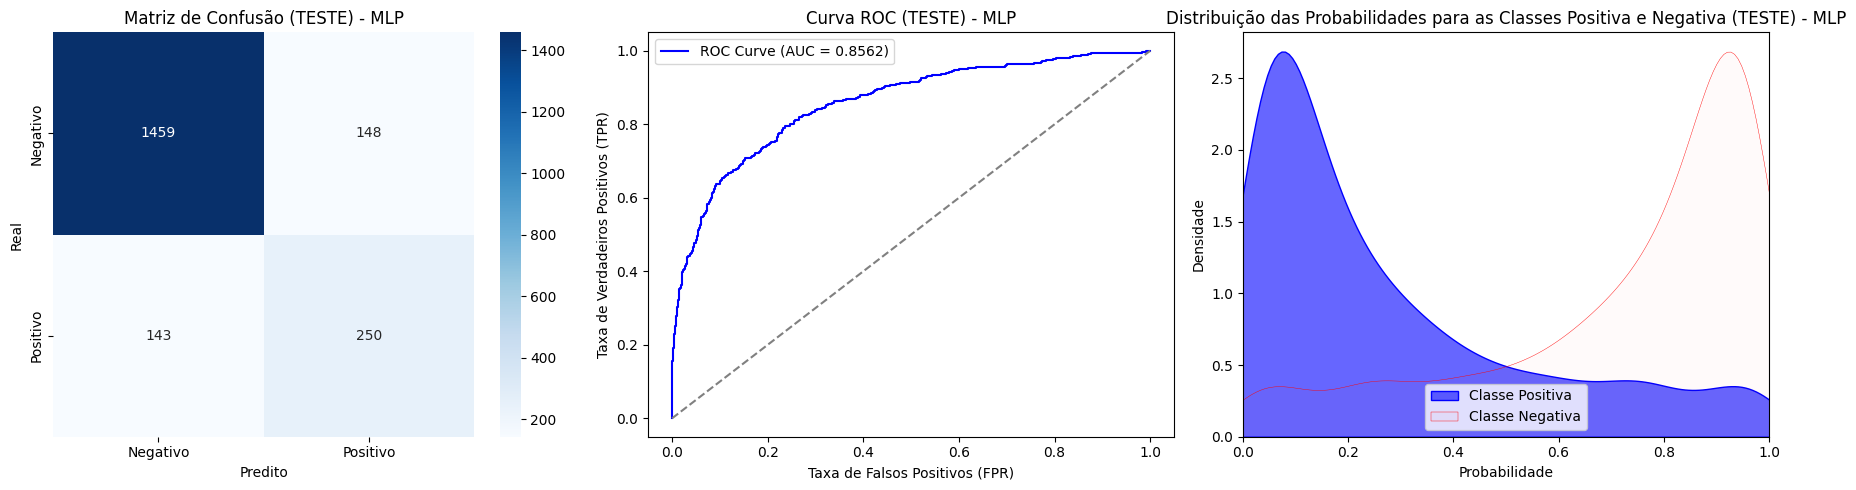

In [20]:
# MLP - PyTorch

# Classe MLP do modelo (reconstrução exata)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, activation, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for units in hidden_layer_sizes:
            self.layers.append(nn.Linear(input_size, units))
            self.layers.append(nn.Dropout(p=dropout_rate))
            input_size = units
        self.output = nn.Linear(input_size, 1)
        self.activation_fn = self.get_activation_function(activation)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = self.output(x)
        return x

    def get_activation_function(self, activation):
        activation_dict = {
            'relu': torch.relu,
            'tanh': torch.tanh,
            'sigmoid': torch.sigmoid,
            'selu': torch.selu,
            'gelu': torch.nn.functional.gelu,
            'leaky_relu': torch.nn.functional.leaky_relu,
            'swish': torch.nn.functional.silu,
            'elu': torch.nn.functional.elu
        }
        return activation_dict.get(activation, torch.relu)

# Definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o scaler
scaler_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\scaler.pth")

#salvando para uso dentro desse notebook, uma copia com formato de joblib / pickle
joblib.dump(scaler_mlp_torch, "scaler_mlp_temp.pkl")

#definindo scaler definitivamente
scaler_mlp_torch = joblib.load("scaler_mlp_temp.pkl")


#apagando scaler_mlp_temp para nao confundir com scaler scaler oficial do ensemble

arquivo = "scaler_mlp_temp.pkl"
if os.path.exists(arquivo):
    os.remove(arquivo)
    print(f"Arquivo {arquivo} removido com sucesso.")
else:
    print(f"Arquivo {arquivo} não encontrado.")



# Normalizar os dados de teste
X_test_scaled = scaler_mlp_torch.transform(X_test)

# Converter X_test para tensor do PyTorch
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Carregar os hiperparâmetros do modelo (ajuste isso se souber os valores exatos)
hidden_layer_sizes = [950, 850]  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 
activation = "relu"  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 
dropout_rate = 0.35657230019086544  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 

# Criar a instância do modelo com os hiperparâmetros corretos
input_size = X_test.shape[1]
model_mlp_torch = MLP(input_size, hidden_layer_sizes, activation, dropout_rate)

# Carregar o modelo salvo
model_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\best_model_inteiro.pth", map_location=device)
model_mlp_torch.to(device)
model_mlp_torch.eval()

# Fazer previsões
with torch.no_grad():
    # Aplicar a função sigmoide para garantir que as probabilidades estejam no intervalo [0, 1]
    y_pred_proba = torch.sigmoid(model_mlp_torch(X_test_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1)
y_pred = (y_pred_proba >= 0.5).astype(int)


# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Exibir as métricas no formato desejado
print("\n📊 MÉTRICAS DO MODELO MLP nos dados de teste")
print("=" * 60)
print(f"{'Métrica':<20}{'Valor final':<15}")
print("-" * 60)
print(f"Acurácia{' ' * 11}{accuracy:.4f}")
print(f"Precisão{' ' * 12}{precision:.4f}")
print(f"Recall{' ' * 14}{recall:.4f}")
print(f"F1-Score{' ' * 12}{f1:.4f}")
print(f"AUC-ROC{' ' * 13}{auc_roc:.4f}")
print(f"MCC{' ' * 17}{mcc:.4f}")
print(f"Kappa de Cohen{' ' * 7}{kappa:.4f}")
print(f"Acurácia Balanceada {balanced_acc:.4f}")
print("=" * 60)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"], ax=axes[0])
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de Confusão (TESTE) - MLP")

# Plot da Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_roc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc_value:.4f})", color="blue")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal
axes[1].set_xlabel("Taxa de Falsos Positivos (FPR)")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
axes[1].set_title("Curva ROC (TESTE) - MLP")
axes[1].legend()

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_proba  
# classe negativa
probs_neg = 1 - y_pred_proba

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - MLP")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)

# Ajuste de layout
plt.tight_layout()
plt.show()




📊 MÉTRICAS DO MODELO XGBOOST nos dados de teste
Métrica                Valor final    
------------------------------------------------------------
Acurácia               0.8425
Precisão               0.5841
Recall                 0.6896
F1-Score               0.6324
AUC-ROC                0.8654
MCC                    0.5361
Kappa de Cohen         0.5331
Acurácia Balanceada    0.7847


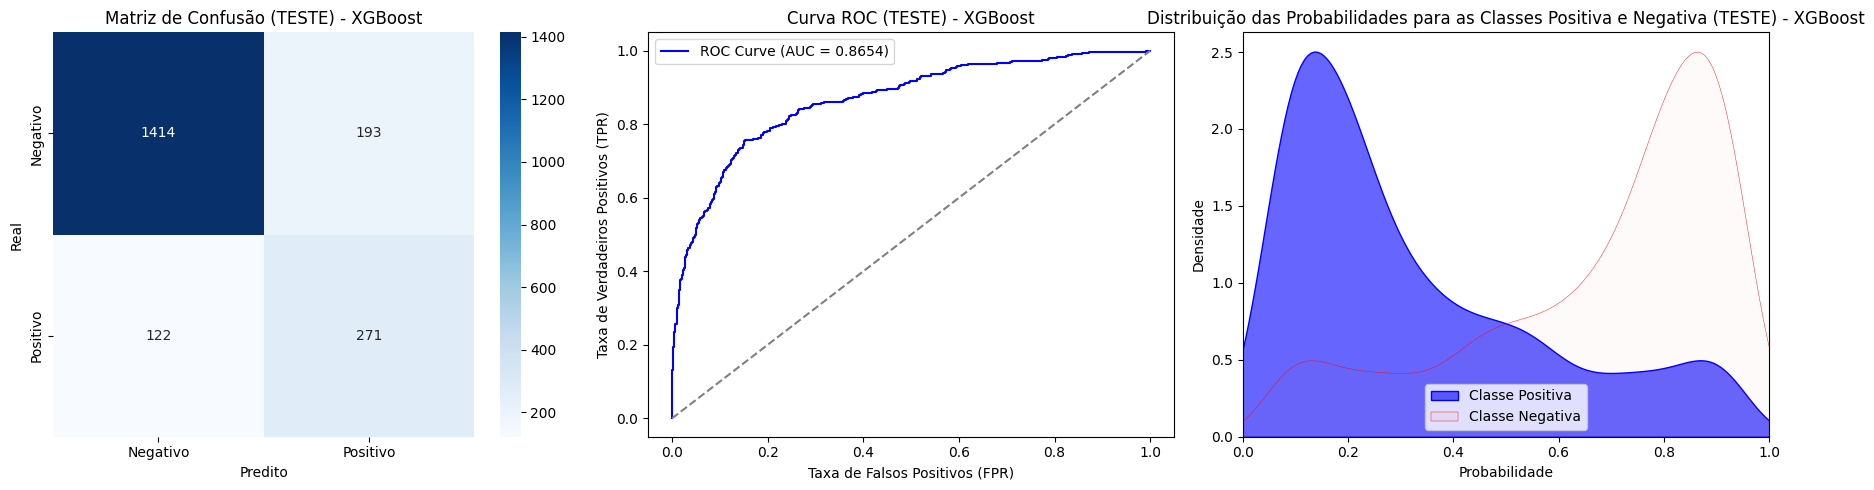

In [21]:
# XGBoost 
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Caminhos dos arquivos
model_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Xgboost\xgb_model.pkl"
scaler_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Xgboost\scaler.pkl"

# Carregar o scaler
scaler_xgb = joblib.load(scaler_path)

# Normalizar os dados de teste
X_test_scaled = scaler_xgb.transform(X_test)

# Carregar o modelo XGBoost
xgb_model = joblib.load(model_path)

# Fazer previsões (probabilidades)
y_pred_prob = xgb_model.predict(xgb.DMatrix(X_test_scaled))

# Converter para classe binária (usando threshold 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Exibir métricas no formato esperado
print("\n📊 MÉTRICAS DO MODELO XGBOOST nos dados de teste")
print("="*60)
print(f"{'Métrica':<22} {'Valor final':<15}")
print("-"*60)
print(f"{'Acurácia':<22} {accuracy:.4f}")
print(f"{'Precisão':<22} {precision:.4f}")
print(f"{'Recall':<22} {recall:.4f}")
print(f"{'F1-Score':<22} {f1:.4f}")
print(f"{'AUC-ROC':<22} {roc_auc:.4f}")
print(f"{'MCC':<22} {mcc:.4f}")
print(f"{'Kappa de Cohen':<22} {kappa:.4f}")
print(f"{'Acurácia Balanceada':<22} {balanced_acc:.4f}")
print("="*60)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"], ax=axes[0])
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de Confusão (TESTE) - XGBoost")

# Plot da Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_value:.4f})", color="blue")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal
axes[1].set_xlabel("Taxa de Falsos Positivos (FPR)")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
axes[1].set_title("Curva ROC (TESTE) - XGBoost")
axes[1].legend()

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_prob  
# classe negativa
probs_neg = 1 - y_pred_prob

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - XGBoost")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)


# Ajuste de layout
plt.tight_layout()
plt.show()

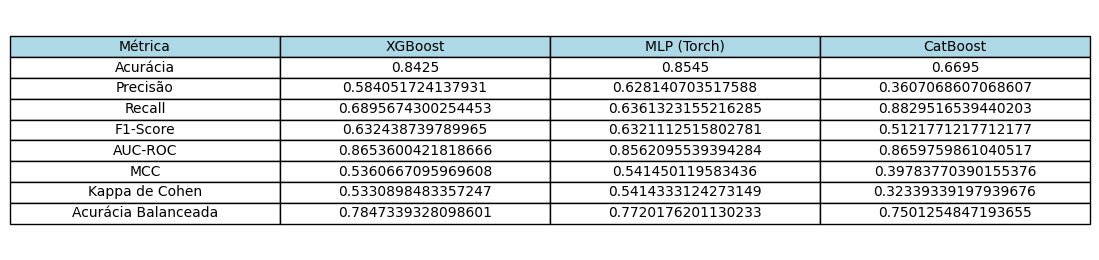

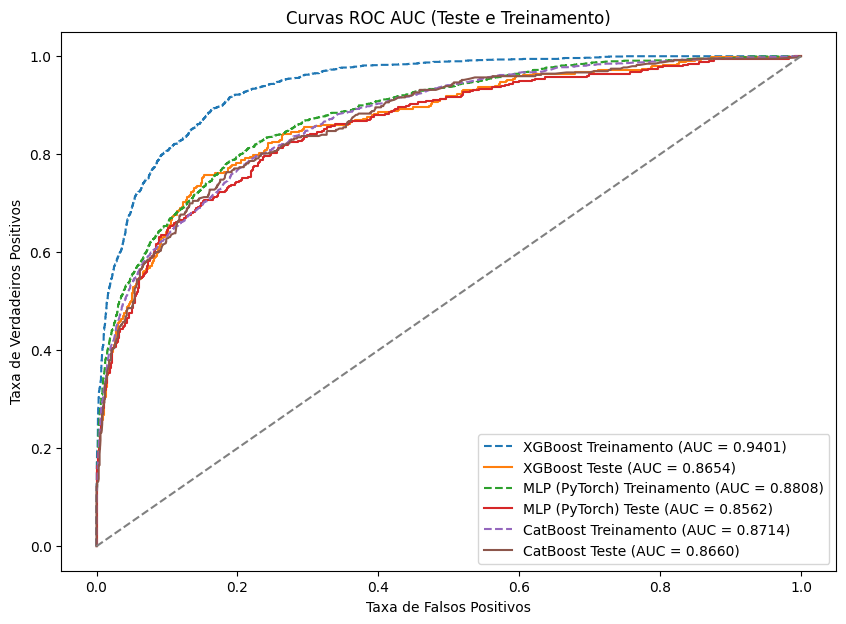

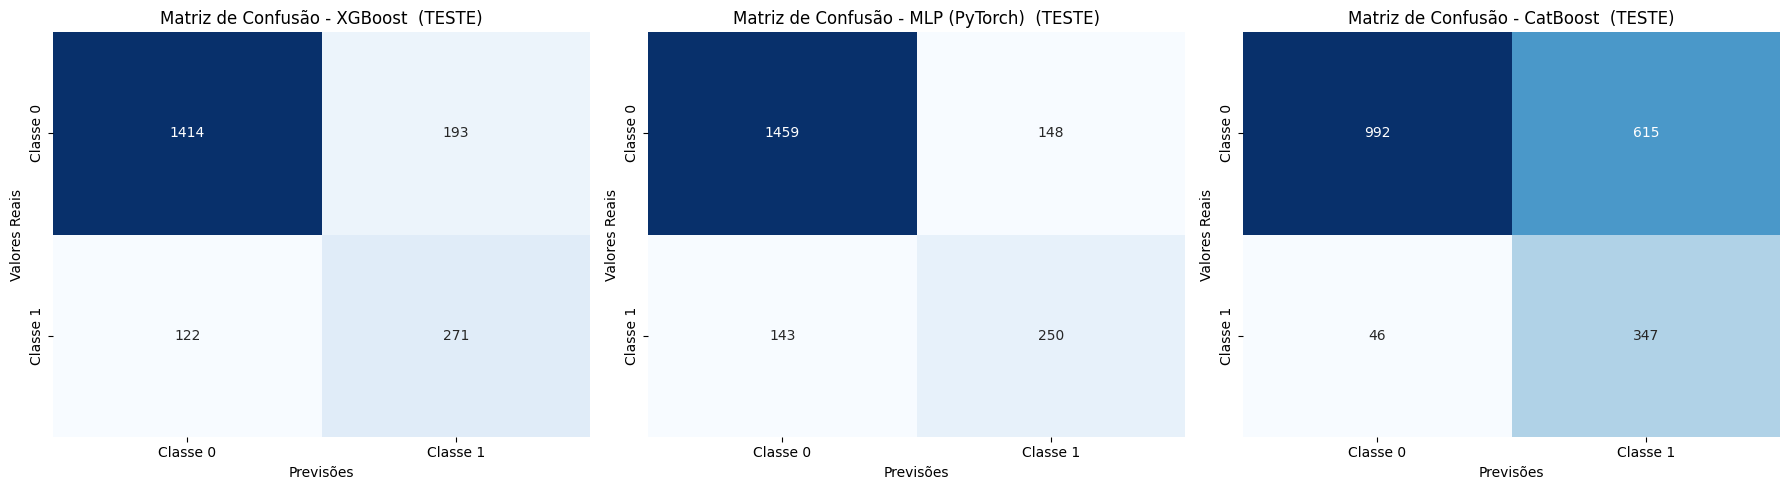

In [22]:
import torch
import xgboost as xgb
import catboost
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------------------------------------
# Normalizar os dados de teste e treino com os scalers corretos
# ----------------------------------------------------------

# XGBoost - Escalonamento com o scaler específico para XGBoost
X_train_scaled_xgb = scaler_xgb.transform(X_train)
X_test_scaled_xgb = scaler_xgb.transform(X_test)

# MLP (Torch) - Escalonamento com o scaler específico para MLP
X_train_scaled_mlp = scaler_mlp_torch.transform(X_train)
X_test_scaled_mlp = scaler_mlp_torch.transform(X_test)

# CatBoost - Escalonamento com o scaler específico para CatBoost
X_train_scaled_catboost = scaler_catboost.transform(X_train)
X_test_scaled_catboost = scaler_catboost.transform(X_test)

# ----------------------------------------------------------
# 1. XGBoost
# ----------------------------------------------------------

# Conjunto de treino
# Previsões no conjunto de treino
y_pred_prob_xgb_ensemble_train = xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb))

# Conjunto de teste
# Fazer previsões (probabilidades)
y_pred_prob_xgb_ensemble_test = xgb_model.predict(xgb.DMatrix(X_test_scaled_xgb))

# Converter para classe binária (usando threshold 0.5)
xgb_y_pred_xgb_ensemble_test_ = (y_pred_prob_xgb_ensemble_test >= 0.5).astype(int)

# Calcular as métricas
xgb_ensemble_accuracy = accuracy_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_precision = precision_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_recall = recall_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_f1 = f1_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_auc_roc = roc_auc_score(y_test, y_pred_prob_xgb_ensemble_test)  # Correção aqui
xgb_ensemble_mcc = matthews_corrcoef(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_kappa = cohen_kappa_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_balanced_acc = balanced_accuracy_score(y_test, xgb_y_pred_xgb_ensemble_test_)

# ----------------------------------------------------------
# 2. MLP (Torch)
# ----------------------------------------------------------

# Normalizar os dados
X_train_scaled = scaler_mlp_torch.transform(X_train)
X_test_scaled = scaler_mlp_torch.transform(X_test)

# Converter para tensor do PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Criar a instância do modelo com os hiperparâmetros corretos
input_size = X_test.shape[1]
model_mlp_torch = MLP(input_size, hidden_layer_sizes, activation, dropout_rate)

# Carregar o modelo salvo
model_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\best_model_inteiro.pth", map_location=device)
model_mlp_torch.to(device)
model_mlp_torch.eval()

# Fazer previsões para os dados de teste
with torch.no_grad():
    # Aplicar a função sigmoide para garantir que as probabilidades estão no intervalo [0, 1]
    y_pred_proba_mlp_ensemble_test = torch.sigmoid(model_mlp_torch(X_test_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1) no conjunto de teste
y_pred_mlp_ensemble_test_ = (y_pred_proba_mlp_ensemble_test >= 0.5).astype(int)

# Fazer previsões para os dados de treino
with torch.no_grad():
    # Aplicar a função sigmoide para garantir que as probabilidades estão no intervalo [0, 1]
    y_pred_proba_mlp_ensemble_train = torch.sigmoid(model_mlp_torch(X_train_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1) no conjunto de treino
y_pred_mlp_ensemble_train_ = (y_pred_proba_mlp_ensemble_train >= 0.5).astype(int)

# Agora, temos as probabilidades e as classes para treino e teste

# Calcular as métricas
mlp_ensemble_accuracy = accuracy_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_precision = precision_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_recall = recall_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_f1 = f1_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_auc_roc = roc_auc_score(y_test, y_pred_proba_mlp_ensemble_test)  # AUC-ROC agora usando as probabilidades (não as classes)
mlp_ensemble_mcc = matthews_corrcoef(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_kappa = cohen_kappa_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_balanced_acc = balanced_accuracy_score(y_test, y_pred_mlp_ensemble_test_)


# ----------------------------------------------------------
# 3. CatBoost
# ----------------------------------------------------------


# Previsões e métricas treino 
# Previsões no conjunto de treino
catboost_y_pred_proba_ensemble_train = model_catboost.predict_proba(X_train_scaled_catboost)[:, 1]
catboost_y_pred_ensemble_train_ = (catboost_y_pred_proba_ensemble_train >= 0.5).astype(int)

# Previsões e métricas teste 
catboost_y_pred_proba_ensemble_teste = model_catboost.predict_proba(X_test_scaled_catboost)[:, 1]
catboost_y_pred_ensemble_teste_ = (catboost_y_pred_proba_ensemble_teste >= 0.5).astype(int)

# Calcular as métricas
catboost_ensemble_accuracy = accuracy_score(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_precision = precision_score(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_recall = recall_score(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_f1 = f1_score(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_auc_roc = roc_auc_score(y_test, catboost_y_pred_proba_ensemble_teste)  # Correção aqui
catboost_ensemble_mcc = matthews_corrcoef(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_kappa = cohen_kappa_score(y_test, catboost_y_pred_ensemble_teste_)
catboost_ensemble_balanced_acc = balanced_accuracy_score(y_test, catboost_y_pred_ensemble_teste_)

# ----------------------------------------------------------
# Exibir as métricas para os três modelos
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

# Dados das métricas de cada modelo
data = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC', 'MCC', 'Kappa de Cohen', 'Acurácia Balanceada'],
    'XGBoost': [xgb_ensemble_accuracy, xgb_ensemble_precision, xgb_ensemble_recall, xgb_ensemble_f1, xgb_ensemble_auc_roc, 
                xgb_ensemble_mcc, xgb_ensemble_kappa, xgb_ensemble_balanced_acc],
    'MLP (Torch)': [mlp_ensemble_accuracy, mlp_ensemble_precision, mlp_ensemble_recall, mlp_ensemble_f1, mlp_ensemble_auc_roc, 
                    mlp_ensemble_mcc, mlp_ensemble_kappa, mlp_ensemble_balanced_acc],
    'CatBoost': [catboost_ensemble_accuracy, catboost_ensemble_precision, catboost_ensemble_recall, catboost_ensemble_f1, catboost_ensemble_auc_roc, 
                 catboost_ensemble_mcc, catboost_ensemble_kappa, catboost_ensemble_balanced_acc]
}

# Criando o DataFrame
metrics_df = pd.DataFrame(data)

# Plotando a tabela com as métricas
fig, ax = plt.subplots(figsize=(10, 3))  # Aumentei a largura para caber melhor os dados
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center', colColours=["lightblue"]*4)

# Ajustando os parâmetros da tabela
table.auto_set_font_size(False)  # Não usar o tamanho automático da fonte
table.set_fontsize(10)  # Definindo o tamanho da fonte para ser menor e caber melhor
table.scale(1.2, 1.2)  # Aumentando o tamanho da tabela para ocupar mais espaço

# Ajustando o layout para remover qualquer espaçamento extra
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

plt.show()


# ----------------------------------------------------------
# Plotar as Curvas ROC AUC dos três modelos, incluindo treino
# ----------------------------------------------------------

plt.figure(figsize=(10, 7))

# ROC Curve - XGBoost (Treinamento)
fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y_train, xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb)))
plt.plot(fpr_xgb_train, tpr_xgb_train, label=f"XGBoost Treinamento (AUC = {roc_auc_score(y_train, xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb))):.4f})", linestyle='--')

# ROC Curve - XGBoost (teste)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb_ensemble_test)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost Teste (AUC = {xgb_ensemble_auc_roc:.4f})")



# ROC Curve - MLP (PyTorch)  (Treinamento)
fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, model_mlp_torch(torch.tensor(X_train_scaled_mlp, dtype=torch.float32).to(device)).cpu().detach().numpy())
plt.plot(fpr_mlp_train, tpr_mlp_train, label=f"MLP (PyTorch) Treinamento (AUC = {roc_auc_score(y_train, model_mlp_torch(torch.tensor(X_train_scaled_mlp, dtype=torch.float32).to(device)).cpu().detach().numpy()):.4f})", linestyle='--')

# ROC Curve - MLP (PyTorch) (teste)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp_ensemble_test)
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (PyTorch) Teste (AUC = {mlp_ensemble_auc_roc:.4f})")



# ROC Curve - CatBoost - (Treinamento)
fpr_catboost_train, tpr_catboost_train, _ = roc_curve(y_train, model_catboost.predict_proba(X_train_scaled_catboost)[:, 1])
plt.plot(fpr_catboost_train, tpr_catboost_train, label=f"CatBoost Treinamento (AUC = {roc_auc_score(y_train, model_catboost.predict_proba(X_train_scaled_catboost)[:, 1]):.4f})", linestyle='--')

# ROC Curve - CatBoost (teste)
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, catboost_y_pred_proba_ensemble_teste)
plt.plot(fpr_catboost, tpr_catboost, label=f"CatBoost Teste (AUC = {catboost_ensemble_auc_roc:.4f})")



# Linha de Chance
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal

plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curvas ROC AUC (Teste e Treinamento)")
plt.legend(loc="lower right")
plt.show()

# ----------------------------------------------------------
# Plotar as Matrizes de Confusão dos três modelos em Subplots
# ----------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Matriz de Confusão - XGBoost nos dados de teste
xgb_cm = confusion_matrix(y_test, xgb_y_pred_xgb_ensemble_test_)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0], 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
axes[0].set_title("Matriz de Confusão - XGBoost  (TESTE)")
axes[0].set_xlabel('Previsões')
axes[0].set_ylabel('Valores Reais')

# Matriz de Confusão - MLP nos dados de teste
mlp_cm = confusion_matrix(y_test, y_pred_mlp_ensemble_test_)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1], 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
axes[1].set_title("Matriz de Confusão - MLP (PyTorch)  (TESTE)")
axes[1].set_xlabel('Previsões')
axes[1].set_ylabel('Valores Reais')

# Matriz de Confusão - CatBoost nos dados de teste 
catboost_cm = confusion_matrix(y_test, catboost_y_pred_ensemble_teste_)
sns.heatmap(catboost_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2], 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
axes[2].set_title("Matriz de Confusão - CatBoost  (TESTE)")
axes[2].set_xlabel('Previsões')
axes[2].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression


# ------------------------------------------------------
# Gerar previsões dos 3 modelos
# ------------------------------------------------------

# Criar DataFrames de treino e teste para as previsões individuais
df_predicoes_train = pd.DataFrame({
    'XGBoost_Prob': y_pred_prob_xgb_ensemble_train,
    'MLP_Torch_Prob': y_pred_proba_mlp_ensemble_train,
    'CatBoost_Prob': catboost_y_pred_proba_ensemble_train
}, index=X_train.index)  # Mantendo o mesmo índice do X_train

df_predicoes_test = pd.DataFrame({
    'XGBoost_Prob': y_pred_prob_xgb_ensemble_test,
    'MLP_Torch_Prob': y_pred_proba_mlp_ensemble_test,
    'CatBoost_Prob': catboost_y_pred_proba_ensemble_teste
}, index=X_test.index)  # Mantendo o mesmo índice do X_test

print(df_predicoes_train.head())
print(df_predicoes_test.head())

# Calcular a média das probabilidades para treino e teste (mantendo apenas a média)
df_predicoes_train_media = pd.DataFrame({
    'Media_Prob': df_predicoes_train.mean(axis=1)
}, index=X_train.index)  # Mantendo o mesmo índice do X_train

df_predicoes_test_media = pd.DataFrame({
    'Media_Prob': df_predicoes_test.mean(axis=1)
}, index=X_test.index)  # Mantendo o mesmo índice do X_test

# Concatenar apenas as médias com os datasets originais
X_train_stacking = pd.concat([X_train, df_predicoes_train_media], axis=1)
X_test_stacking = pd.concat([X_test, df_predicoes_test_media], axis=1)


# Exibir as primeiras linhas para conferir se as probs estao vindo certo
print('---------------------------------------------------------------------------' ) #so pra separar os prints
print(X_train_stacking.head())
print(X_test_stacking.head())





#testando modelos para serrem metamodels(aqui so anota mesmo)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Criar o modelo de regressão logística # BOM MAS NEM TANTO
#meta_model = LogisticRegression()

# Criar o modelo XGBoost #EM TESTE
#meta_model = XGBClassifier(random_state=42) 



# Criar o modelo de árvore de decisão #A TESTAR
#meta_model = DecisionTreeClassifier(random_state=42)  

# Criar o modelo de Máquina de Vetores de Suporte (SVM) #A TESTAR
#meta_model = SVC(probability=True, random_state=42)

# Criar o modelo Random Forest#A TESTAR
#meta_model = RandomForestClassifier(random_state=42)

# Criar o modelo CatBoost#A TESTAR
#meta_model = CatBoostClassifier(random_state=42, verbose=0)

# Criar o modelo LightGBM#A TESTAR
#meta_model = LGBMClassifier(random_state=42)





      XGBoost_Prob  MLP_Torch_Prob  CatBoost_Prob
9254      0.076891        0.017715       0.172448
1561      0.179204        0.116131       0.547495
1670      0.334908        0.115627       0.432800
6087      0.338497        0.148216       0.432800
6669      0.887759        0.806027       0.821856
      XGBoost_Prob  MLP_Torch_Prob  CatBoost_Prob
6252      0.133134        0.084365       0.407882
4684      0.146761        0.058638       0.360759
1731      0.221194        0.144901       0.464269
4742      0.373260        0.283899       0.679368
4521      0.175500        0.078866       0.364226
---------------------------------------------------------------------------
      CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Satisfaction Score  Card Type  Point Earned  Geography_Germany  Balance_Squared  Age_Squared  CreditScore_Squared  Tenure_Squared  EstimatedSalary_Squared  Media_Prob
9254        686.0  32.0     6.0       0.00            

In [24]:
#verificando balanceametno final (morrer de certeza)
print(round(y_train.value_counts(normalize=True)*100,1))

#continuam naturalmente desbalanceadas 




Exited
0    79.4
1    20.6
Name: proportion, dtype: float64


In [25]:
#Calcular o peso ideal para scale_pos_weight quando esta desbalanceado: pode ser pelo calculo de 
# razão inversa das proporções das classes (boa pratica pra dar um norte de onde comecar a explorar o hiperparametro scale_pos_weight):

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight
 
# isso significa que a classe 0 (Negativa) é 3.86 vezes maior que a positiva (1)

# o estudo de scale_pos_weight melhor foi necessario por o modelo estava propenso a definir a maioria dos casos como negativo por conta dos baixos valores de probabilidade (muito pelo threshold tbm). 


3.86322188449848

Otimização em andamento: 100%|██████████| 1000/1000 [43:35<00:00,  2.62s/trial]


📊 MELHORES HIPERPARÂMETROS ENCONTRADOS
════════════════════════════════════════════════════════════
Hiperparâmetro           Valor          
────────────────────────────────────────────────────────────
learning_rate            0.13733017741107575
n_estimators             50             
max_depth                9              
min_child_weight         5              
subsample                0.34162170716845514
colsample_bytree         0.8895223619465126
colsample_bylevel        0.2450789752015998
colsample_bynode         0.8812789023723776
lambda                   0.47291226160149763
alpha                    2.0426599596011177
scale_pos_weight         7.418233977063669
max_delta_step           0.775693660460751
early_stopping_rounds    70             
max_bin                  124            
min_data_in_leaf         38             
════════════════════════════════════════════════════════════
✅ Otimização concluída!
Training until validation scores don't improve for 70 rounds
Did not m

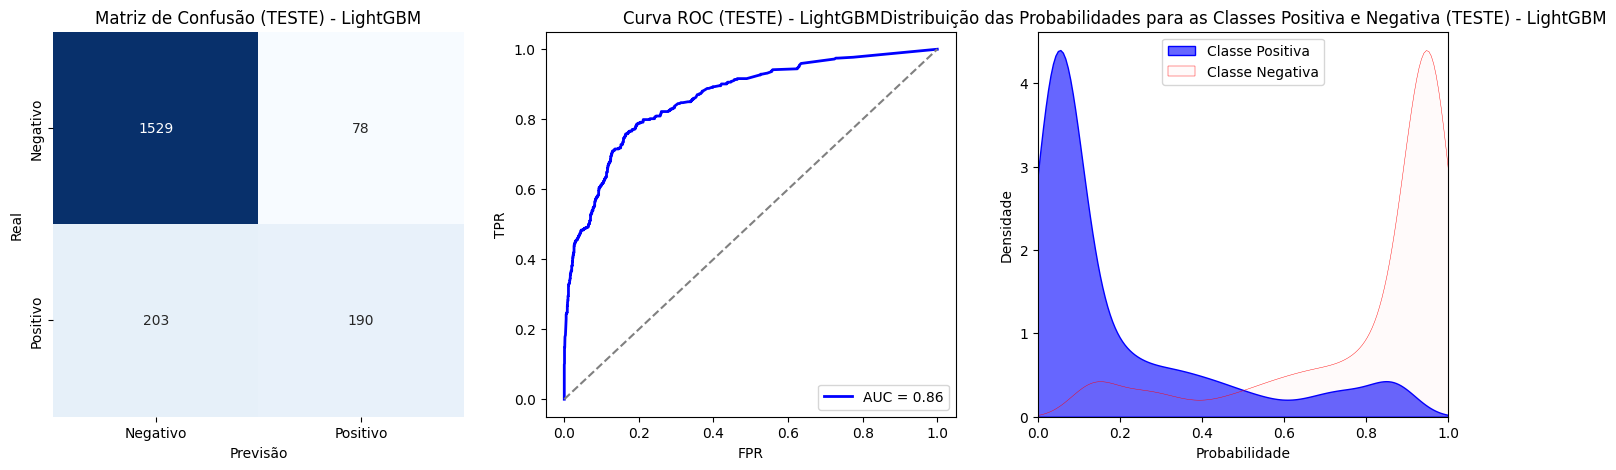

<Figure size 640x480 with 0 Axes>

In [26]:
n_trials_ = 1000

# Criando uma barra de progresso
progress_bar = tqdm(total=n_trials_, desc="Otimização em andamento", unit="trial")

# Definindo os pesos das métricas para otimização do treino
weights_skf = {
    'Accuracy': 0.00,       # Não é útil para calibração
    'f1': 0.15,             # Mantém equilíbrio entre precision e recall, mas não domina a decisão
    'precision': 0.20,      # Reduzido para não favorecer previsões muito conservadoras
    'recall': 0.45,         # Ainda alto para não perder churns, mas sem sobrecarregar
    'auc': 0.10,            # Importante pois afeta a ordenação das probabilidades
    'balanced_acc': 0.10,   # Pequena influência na adaptação a desbalanceamento
    'mcc': 0.00             # Não é essencial para calibração direta
}




def objective(trial):
    global progress_bar
    # Verificando se há GPU disponível para processar
    use_gpu = torch.cuda.is_available()

    # Definir as opções para 'device' dependendo da disponibilidade da GPU
    device = 'gpu' if use_gpu else 'cpu'

    # Sugerindo os parâmetros do LightGBM
    objective = 'binary'

    # Parâmetros ajustados de maneira mais adequada
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0002, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 100, 500)  
    max_depth = trial.suggest_int('max_depth', 3, 9)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    subsample = trial.suggest_uniform('subsample', 0.2, 0.8)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 0.9)
    colsample_bylevel = trial.suggest_uniform('colsample_bylevel', 0.2, 0.9)
    colsample_bynode = trial.suggest_uniform('colsample_bynode', 0.2, 0.9)
    lambda_reg = trial.suggest_loguniform('lambda', 0.1, 10.0)
    alpha = trial.suggest_loguniform('alpha', 0.1, 10.0)
    scale_pos_weight = trial.suggest_loguniform('scale_pos_weight', 2, 8) #considerando o calculo anterior (razão inversa das proporções das classes)
    max_delta_step = trial.suggest_uniform('max_delta_step', 0.1, 1.0)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 10, 70)

    # Novos parâmetros adicionados
    max_bin = trial.suggest_int('max_bin', 50, 250)  # Ajuste no número de bins
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 50)  # Número mínimo de dados por folha

    # Parâmetros de controle de log
    
    verbose = -1  # Controla a exibição dos logs (deve ser configurado como -1 para não exibir)

    # Definindo os parâmetros do LightGBM
    params = {
        'objective': objective,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bynode': colsample_bynode,
        'lambda_l1': lambda_reg,
        'alpha': alpha,
        'scale_pos_weight': scale_pos_weight,
        'max_delta_step': max_delta_step,
        'max_bin': max_bin,
        'min_data_in_leaf': min_data_in_leaf,
        'early_stopping_rounds': early_stopping_rounds,
        'verbose': verbose,
        'device':device
    }


    # Validando o modelo com a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    global weights_skf
    weighted_scores = []
    auc_roc_list, accuracy_list, precision_list, recall_list, f1_list, mcc_list, kappa_list, balanced_acc_list = [], [], [], [], [], [], [], []

    for train_idx, val_idx in skf.split(X_train_stacking, y_train):
        X_train_fold, X_val_fold = X_train_stacking.iloc[train_idx], X_train_stacking.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Criando o dataset para o LightGBM
        dtrain = lgb.Dataset(X_train_fold, label=y_train_fold)
        dval = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            valid_names=['validation']
            
        )

        # Prevendo probabilidades de classe 1
        y_pred_prob = model.predict(X_val_fold)
        y_pred = (y_pred_prob >= 0.5).astype(int)

        auc_roc_list.append(roc_auc_score(y_val_fold, y_pred_prob))
        accuracy_list.append(accuracy_score(y_val_fold, y_pred))
        precision_list.append(precision_score(y_val_fold, y_pred, zero_division=0))
        recall_list.append(recall_score(y_val_fold, y_pred))
        f1_list.append(f1_score(y_val_fold, y_pred))
        mcc_list.append(matthews_corrcoef(y_val_fold, y_pred))
        kappa_list.append(cohen_kappa_score(y_val_fold, y_pred))
        balanced_acc_list.append(balanced_accuracy_score(y_val_fold, y_pred))

        # Métricas para otimizar de maneira ponderada
        metrics = {
            "AUC-ROC": np.mean(auc_roc_list),
            "Accuracy": np.mean(accuracy_list),
            "Precision": np.mean(precision_list),
            "Recall": np.mean(recall_list),
            "F1-Score": np.mean(f1_list),
            "MCC": np.mean(mcc_list),
            "Kappa": np.mean(kappa_list),
            "Balanced Accuracy": np.mean(balanced_acc_list),
        }

        weighted_score = (
            weights_skf['f1'] * metrics["F1-Score"] +
            weights_skf['precision'] * metrics["Precision"] +
            weights_skf['recall'] * metrics["Recall"] +
            weights_skf['auc'] * metrics["AUC-ROC"] +
            weights_skf['balanced_acc'] * metrics["Balanced Accuracy"] +
            weights_skf['Accuracy'] * metrics["Accuracy"] +
            weights_skf['mcc'] * metrics["MCC"]
        )
        weighted_scores.append(weighted_score)

    # Retorno da média da métrica ponderada para otimização
    progress_bar.update(1)
    
    return np.mean(weighted_scores)

# Otimização com Optuna
sampler_ = optuna.samplers.TPESampler(
    n_startup_trials=50,
    n_ei_candidates=20,
    seed=42,
    multivariate=True
)

study = optuna.create_study(direction='maximize', sampler=sampler_)
study.optimize(objective, n_trials=n_trials_)
best_params = study.best_params

# Melhores hiperparâmetros
print("📊 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("═" * 60)
print(f"{'Hiperparâmetro':<25}{'Valor':<15}")
print("─" * 60)
for param, value in best_params.items():
    value = value if value is not None else "N/A"
    print(f"{param:<25}{value:<15}")
print("═" * 60)

print("✅ Otimização concluída!")
progress_bar.close()

# Criando e treinando o modelo final com os melhores parâmetros
final_params = best_params.copy()
final_params['metric'] = 'binary_logloss'
#auc -> mede usa a curva auc, ou seja a capacidade geral de classificar entre positivos e negativos 
#binary_logloss → Mede o quão bem calibradas estão as probabilidades.
#average_precision → Mede a área sob a curva de precisão-recall (boa para desbalanceamento).


# Criando os datasets para o LightGBM
dtrain_final = lgb.Dataset(X_train_stacking, label=y_train)
dtest_final = lgb.Dataset(X_test_stacking, label=y_test, reference=dtrain_final)

# Treinando o modelo com os melhores parâmetros encontrados
final_model = lgb.train(final_params, dtrain_final, num_boost_round=best_params['n_estimators'], valid_sets=[dtest_final])

# Previsões e métricas no conjunto de teste
y_pred_final_prob = final_model.predict(X_test_stacking)
y_pred_final = (y_pred_final_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
gini = (2 * auc_roc - 1) * 100
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
auc_roc = roc_auc_score(y_test, y_pred_final_prob)
mcc = matthews_corrcoef(y_test, y_pred_final)
kappa = cohen_kappa_score(y_test, y_pred_final)
balanced_acc = balanced_accuracy_score(y_test, y_pred_final)

# Exibir as métricas finais
print("📊 MÉTRICAS FINAIS - TESTE")
print("=" * 60)
print(f"{'Métrica':<25} {'Valor final'}")
print("-" * 60)
print(f"{'Acurácia':<25} {accuracy:.4f}")
print(f"{'Precisão':<25} {precision:.4f}")
print(f"{'Recall':<25} {recall:.4f}")
print(f"{'F1-Score':<25} {f1:.4f}")
print(f"{'AUC-ROC':<25} {auc_roc:.4f}")
print(f"{'MCC':<25} {mcc:.4f}")
print(f"{'Kappa':<25} {kappa:.4f}")
print(f"{'Balanced Accuracy':<25} {balanced_acc:.4f}")
print(f"{'Gini':<25} {gini:.4f}")
print("=" * 60)



# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'],
            cbar=False, ax=axes[0])
axes[0].set_title('Matriz de Confusão (TESTE) - LightGBM')
axes[0].set_xlabel('Previsão')
axes[0].set_ylabel('Real')

# Plot da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final_prob)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Curva ROC (TESTE) - LightGBM')
axes[1].legend(loc='lower right')

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_final_prob  
# classe negativa
probs_neg = 1 - y_pred_final_prob

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - LightGBM")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)


# Exibindo o gráfico
plt.show()

# Ajustando o layout
plt.tight_layout()
plt.show()



# Explicabilidade 

# Feature Importance (Global)

* Feature Importance é uma técnica de explicabilidade que ajuda a identificar quais variáveis (features) têm maior impacto nas predições de um modelo. Ela mede a contribuição de cada feature para a construção do modelo, permitindo entender quais variáveis são mais relevantes para as decisões do modelo.

A Feature Importance tem um parâmetro chamado importance_type, que determina o tipo de métrica usada para calcular a importância de cada feature:

* gain: Mede a contribuição de uma feature para melhorar a acurácia do modelo, ou seja, quanto ela ajuda a melhorar a qualidade da predição em cada divisão.


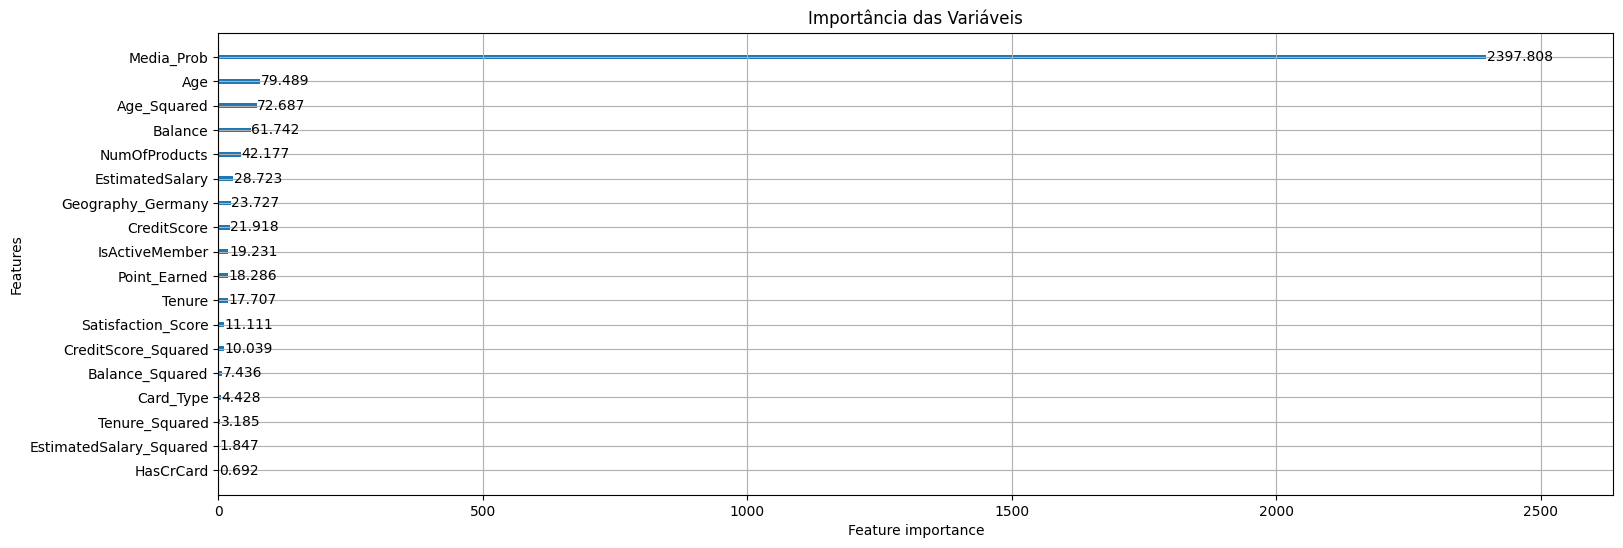

In [27]:
import matplotlib.pyplot as plt

# Criando uma figura com tamanho ajustado
fig, ax = plt.subplots(figsize=(18, 6))  # Ajuste o tamanho aqui

# Plotando a importância das variáveis na figura e eixo específicos
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', title='Importância das Variáveis', ax=ax)

# Exibindo o gráfico
plt.show()


# SHAP Global

* SHAP Global é uma técnica de explicabilidade que ajuda a entender a importância de cada variável (feature) nas predições do modelo de maneira global, ou seja, avaliando o impacto médio de cada feature ao longo de todas as instâncias do conjunto de dados.




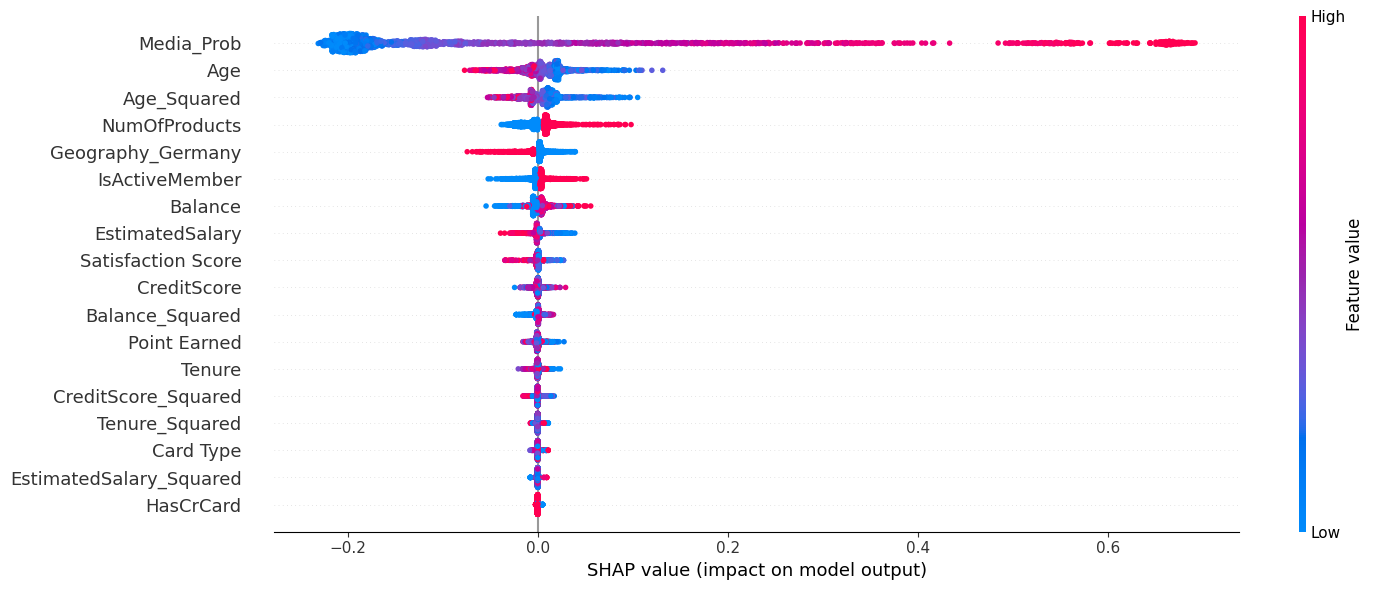

In [28]:

# 2. SHAP (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(final_model)

# Se X_test_stacking for um DMatrix, converta para pandas DataFrame ou array denso
if isinstance(X_test_stacking, xgb.DMatrix):
    X_test_stacking = X_test_stacking.get_data()

# Se X_test_stacking for um csr_matrix, converta para array denso
if isinstance(X_test_stacking, scipy.sparse.csr_matrix):
    X_test_stacking = X_test_stacking.toarray()

# Calcular os valores SHAP
shap_values = explainer.shap_values(X_test_stacking)


shap.summary_plot(shap_values, X_test_stacking, plot_size=(15, 6))  # Altere os valores conforme necessário




# LIME (Local) 

* LIME (Local Interpretable Model-agnostic Explanations) é uma técnica de explicabilidade que busca interpretar predições de modelos de forma local, ou seja, explicar como o modelo chegou a uma decisão específica para uma instância de dado individual. 

* Ao contrário de métodos globais, como o SHAP, que explicam a importância das features em todas as predições, o LIME foca na explicação de uma única predição.

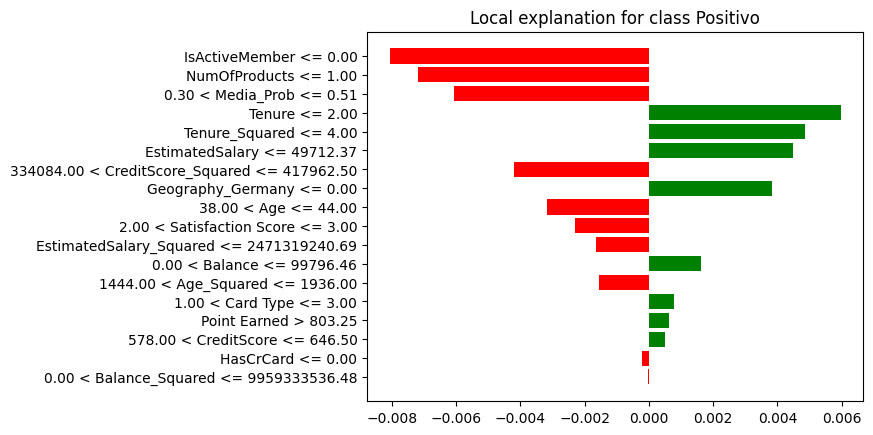

In [29]:
# Criando o explicador LIME para um modelo LightGBM
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test_stacking.values,  # Dados de treino
    training_labels=y_test.values,         # Rótulos de treino
    mode="classification",                  # Tipo de problema (classificação)
    class_names=["Negativo", "Positivo"],   # Nomes das classes
    feature_names=X_test_stacking.columns, # Nomes das features
    discretize_continuous=True              # Discretizar variáveis contínuas
)

# Selecionando uma instância para explicar
idx = 200  # Índice do exemplo/observação a ser explicado
instance = X_test_stacking.iloc[idx].values.reshape(1, -1)

# Função para obter probabilidades usando LightGBM (para classificação binária)
def predict_proba_fn(x):
    raw_preds = final_model.predict(x)  # Usando o método predict do LightGBM
    # Convertendo as margens (logits) para probabilidades
    probabilities = 1 / (1 + np.exp(-raw_preds))  # Sigmoide para classificação binária
    return np.array([1 - probabilities, probabilities]).T  # Retorna a probabilidade para cada classe

# Gerando explicação local com probabilidades de classe
explanation = explainer.explain_instance(
    instance.flatten(),  # Passando os valores da instância em um formato adequado
    predict_proba_fn,     # Usando a função que retorna as probabilidades
    num_features=40      # Número de características a serem mostradas
)

# Plotando a explicação
fig = explanation.as_pyplot_figure()
plt.show()

# Gerando gráfico de importância das características (se necessário)
# explanation.as_list()  # Para mostrar os valores, tipo print


In [30]:
#os valores de shap e do lime indicam que a variavel de XGboost (probabilidade) esta atrapalhando mais que ajudado, acho que trocar ela por outro modelo seja mais interessante,

# mas antes, tentar algum balanceametno (undersampling etc, so por desencargo)

# APLIQUEI SMOTE SE NAO MELHORAR MELHOR TIRAR 